#Abstract

The objective of this assignment is to develop a predictive model to assess the creditworthiness of individuals based on various financial and personal variables. This analysis aims to distinguish between applicants likely to fulfill their credit obligations and those who may default. To achieve this, we will employ several modeling techniques and interpret their outcomes to identify the most significant predictors of credit risk.

In this notebook, we will execute the following tasks:

Fit a linear model to the application records and interpret its coefficients.
Develop a tree-based model using the credit records and explain the importance of features through the structure of the trees.
Utilize an automated machine learning framework to identify the most effective model for predicting creditworthiness.
Conduct SHAP (SHapley Additive exPlanations) analysis on the models from steps 1, 2, and 3 to interpret the impact of each feature on the model's prediction. We will compare these interpretations with other model interpretability methods to assess their consistency and reliability.

#Dataset

###Link to Dataset: https://github.com/bhagyatrivedi/DSEM_dataset

The dataset consists of socio-economic information and credit card bill payments related information of the customers. Such data helps the financial institutions to predict if an applicant is 'good' or 'bad' client and whehter their credit card should be approved or not.

The dataset consists of 2 csv files.

* **application_record.csv** - It is the table that has information about the customer regarding their application, financial and household information including all the assets.

1. `ID`: `Client identification number`
2. `CODE_GEN`: `Client gender`
3. `FLAG_OWN_CAR`: `Is there a car?`
4. `FLAG_OWN_REALTY`: `Is there a property?`
5. `CNT_CHILDREN`: `Number of children`
6. `AMT_INCOME_TOTAL`: `Total annual income`
7. `NAME_INCOME_TYPE`: `Income category`
8. `NAME_EDUCATION_TYPE`: `Education level of the client`
9. `NAME_FAMILY_STATUS`: `Marital status`
10. `NAME_HOUSING_TYPE`: `Type of living`
11. `DAYS_BIRTH`: `	Count backwards from current day (0), -1 means yesterday`
12. `DAYS_EMPLOYED`: `Count backwards from current day(0). If positive, it means the person currently unemployed.`
13. `FLAG_MOBIL`: `Is there a mobile phone?`
14. `FLAG_WORK_PHONE`: `Is there a work phone?`
15. `FLAG_PHONE`: `Is there a phone?`
16. `FLAG_EMAIL`: `Is there any email?`
17. `OCCUPATION_TYPE`: `Occupation of the client`
18. `CNT_FAM_MEMBERS`: `Size of the Family`

* **credit_records.csv** - It its the table that has all the payment related information for a given customer.

1. `ID`: `Client identification number`
2. `MONTH_BALANCE`: `The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on`
3. `STATUS`: `0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month`

Both the tables are connected with `ID`.

In [1]:
pip install pydotplus

In [2]:
#data manupulation
import pandas as pd
#numerical combination
import numpy as np
#plotting data and create visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from plotly.subplots import make_subplots
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.tree import plot_tree
import pydotplus #pip install pydotplus
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor

import xgboost as xgb
from xgboost import plot_importance


In [3]:
df1 = pd.read_csv('https://raw.githubusercontent.com/bhagyatrivedi/DSEM_dataset/main/application_record.csv');

In [4]:
df1.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  
0              2.0  
1              2.0  
2              2.0  
3              1.0  
4              1.0

In [5]:
df1.shape

(438557, 18)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [7]:
df1['ID'].duplicated().sum()

47

In [8]:
df1 = df1.drop_duplicates(subset='ID',keep='first')

In [9]:
df1.shape

(438510, 18)

In [10]:
df1.columns[1:]

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

In [11]:
df1.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134193
CNT_FAM_MEMBERS             0
dtype: int64

In [12]:
df1['NAME_INCOME_TYPE'].unique()

array(['Working', 'Commercial associate', 'Pensioner', 'State servant',
       'Student'], dtype=object)

In [13]:
df1['NAME_EDUCATION_TYPE'].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [14]:
df1['NAME_FAMILY_STATUS'].unique()

array(['Civil marriage', 'Married', 'Single / not married', 'Separated',
       'Widow'], dtype=object)

In [15]:
df1['NAME_HOUSING_TYPE'].unique()

array(['Rented apartment', 'House / apartment', 'Municipal apartment',
       'With parents', 'Co-op apartment', 'Office apartment'],
      dtype=object)

In [16]:
df1['FLAG_MOBIL'].value_counts()

1    438510
Name: FLAG_MOBIL, dtype: int64

In [17]:
df1['FLAG_WORK_PHONE'].unique()

array([1, 0])

In [18]:
df1['FLAG_PHONE'].unique()

array([0, 1])

In [19]:
df1['FLAG_EMAIL'].unique()

array([0, 1])

In [20]:
df1['OCCUPATION_TYPE'].value_counts(dropna=False)

NaN                      134193
Laborers                  78231
Core staff                43000
Sales staff               41094
Managers                  35481
Drivers                   26090
High skill tech staff     17285
Accountants               15983
Medicine staff            13518
Cooking staff              8076
Security staff             7993
Cleaning staff             5843
Private service staff      3455
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: OCCUPATION_TYPE, dtype: int64

In [21]:
df1['OCCUPATION_TYPE'].fillna('not_specified',inplace=True)

In [22]:
df1['OCCUPATION_TYPE'].value_counts(dropna=False)

not_specified            134193
Laborers                  78231
Core staff                43000
Sales staff               41094
Managers                  35481
Drivers                   26090
High skill tech staff     17285
Accountants               15983
Medicine staff            13518
Cooking staff              8076
Security staff             7993
Cleaning staff             5843
Private service staff      3455
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: OCCUPATION_TYPE, dtype: int64

In [23]:
df1.describe(percentiles=[.01,.02,.03,.04,.05,.1,.25,.5,.75,.9,.95,.96,.97,.98,.99]).T

count          mean            std        min  \
ID                438510.0  6.022035e+06  571496.239776  5008804.0   
CNT_CHILDREN      438510.0  4.273814e-01       0.724874        0.0   
AMT_INCOME_TOTAL  438510.0  1.875254e+05  110089.279583    26100.0   
DAYS_BIRTH        438510.0 -1.599802e+04    4185.016222   -25201.0   
DAYS_EMPLOYED     438510.0  6.056619e+04  138770.072835   -17531.0   
FLAG_MOBIL        438510.0  1.000000e+00       0.000000        1.0   
FLAG_WORK_PHONE   438510.0  2.061276e-01       0.404524        0.0   
FLAG_PHONE        438510.0  2.877699e-01       0.452724        0.0   
FLAG_EMAIL        438510.0  1.082005e-01       0.310634        0.0   
CNT_FAM_MEMBERS   438510.0  2.194463e+00       0.897192        1.0   

                          1%          2%          3%          4%          5%  \
ID                5024429.09  5041533.18  5054216.27  5068686.36  5091807.45   
CNT_CHILDREN            0.00        0.00        0.00        0.00        0.00   
AMT_INCOME_TOTAL    54000.00    67500.00    67500.00    72000.00    76500.00   
DAYS_BIRTH         -24013.00   -23642.00   -23413.00   -23181.00   -22972.00   
DAYS_EMPLOYED      -10913.00    -9533.00    -8486.00    -7792.00    -7205.00   
FLAG_MOBIL              1.00        1.00        1.00        1.00        1.00   
FLAG_WORK_PHONE         0.00        0.00        0.00        0.00        0.00   
FLAG_PHONE              0.00        0.00        0.00        0.00        0.00   
FLAG_EMAIL              0.00        0.00        0.00        0.00        0.00   
CNT_FAM_MEMBERS         1.00        1.00        1.00        1.00        1.00   

                        10%         25%         50%         75%        90%  \
ID                5181098.9  5609362.25  6047719.50  6454160.75  6722537.1   
CNT_CHILDREN            0.0        0.00        0.00        1.00        2.0   
AMT_INCOME_TOTAL    90000.0   121500.00   160940.25   225000.00   315000.0   
DAYS_BIRTH         -21982.0   -19484.00   -15630.00   -12514.00   -10519.0   
DAYS_EMPLOYED       -5295.0    -3103.00    -1467.00     -371.00   365243.0   
FLAG_MOBIL              1.0        1.00        1.00        1.00        1.0   
FLAG_WORK_PHONE         0.0        0.00        0.00        0.00        1.0   
FLAG_PHONE              0.0        0.00        0.00        1.00        1.0   
FLAG_EMAIL              0.0        0.00        0.00        0.00        1.0   
CNT_FAM_MEMBERS         1.0        2.00        2.00        3.00        3.0   

                         95%         96%        97%         98%         99%  \
ID                6800362.55  6830288.64  7009897.1  7271099.44  7636888.19   
CNT_CHILDREN            2.00        2.00        2.0        2.00        3.00   
AMT_INCOME_TOTAL   360000.00   382500.00   405000.0   450000.00   540000.00   
DAYS_BIRTH          -9889.00    -9655.00    -9343.0    -9011.00    -8575.00   
DAYS_EMPLOYED      365243.00   365243.00   365243.0   365243.00   365243.00   
FLAG_MOBIL              1.00        1.00        1.0        1.00        1.00   
FLAG_WORK_PHONE         1.00        1.00        1.0        1.00        1.00   
FLAG_PHONE              1.00        1.00        1.0        1.00        1.00   
FLAG_EMAIL              1.00        1.00        1.0        1.00        1.00   
CNT_FAM_MEMBERS         4.00        4.00        4.0        4.00        5.00   

                        max  
ID                7999952.0  
CNT_CHILDREN           19.0  
AMT_INCOME_TOTAL  6750000.0  
DAYS_BIRTH          -7489.0  
DAYS_EMPLOYED      365243.0  
FLAG_MOBIL              1.0  
FLAG_WORK_PHONE         1.0  
FLAG_PHONE              1.0  
FLAG_EMAIL              1.0  
CNT_FAM_MEMBERS        20.0

In [24]:
df1['DAYS_EMPLOYED'].max()

365243

In [25]:
df1[df1['DAYS_EMPLOYED']>=0]['DAYS_EMPLOYED'].value_counts()

365243    75324
Name: DAYS_EMPLOYED, dtype: int64

In [26]:
df1['DAYS_EMPLOYED'].replace(365243,0,inplace=True)

In [27]:
df1[df1['DAYS_EMPLOYED']>=0]['DAYS_EMPLOYED'].value_counts()

0    75324
Name: DAYS_EMPLOYED, dtype: int64

In [28]:
df1['AGE_YEARS']=round(-df1['DAYS_BIRTH']/365.2425,0)

In [29]:
df1['YEARS_EMPLOYED']=round(-df1['DAYS_EMPLOYED']/365.2425)
df1.loc[df1['YEARS_EMPLOYED']<0,'YEARS_EMPLOYED']=0

In [30]:
df1.drop(columns=["DAYS_BIRTH","DAYS_EMPLOYED"],inplace=True)

In [31]:
df1.describe(percentiles=[.01,.02,.03,.04,.05,.1,.25,.5,.75,.9,.95,.96,.97,.98,.99]).T

count          mean            std        min  \
ID                438510.0  6.022035e+06  571496.239776  5008804.0   
CNT_CHILDREN      438510.0  4.273814e-01       0.724874        0.0   
AMT_INCOME_TOTAL  438510.0  1.875254e+05  110089.279583    26100.0   
FLAG_MOBIL        438510.0  1.000000e+00       0.000000        1.0   
FLAG_WORK_PHONE   438510.0  2.061276e-01       0.404524        0.0   
FLAG_PHONE        438510.0  2.877699e-01       0.452724        0.0   
FLAG_EMAIL        438510.0  1.082005e-01       0.310634        0.0   
CNT_FAM_MEMBERS   438510.0  2.194463e+00       0.897192        1.0   
AGE_YEARS         438510.0  4.380453e+01      11.465521       21.0   
YEARS_EMPLOYED    438510.0  5.956069e+00       6.574244        0.0   

                          1%          2%          3%          4%          5%  \
ID                5024429.09  5041533.18  5054216.27  5068686.36  5091807.45   
CNT_CHILDREN            0.00        0.00        0.00        0.00        0.00   
AMT_INCOME_TOTAL    54000.00    67500.00    67500.00    72000.00    76500.00   
FLAG_MOBIL              1.00        1.00        1.00        1.00        1.00   
FLAG_WORK_PHONE         0.00        0.00        0.00        0.00        0.00   
FLAG_PHONE              0.00        0.00        0.00        0.00        0.00   
FLAG_EMAIL              0.00        0.00        0.00        0.00        0.00   
CNT_FAM_MEMBERS         1.00        1.00        1.00        1.00        1.00   
AGE_YEARS              23.00       25.00       26.00       26.00       27.00   
YEARS_EMPLOYED          0.00        0.00        0.00        0.00        0.00   

                        10%         25%         50%         75%        90%  \
ID                5181098.9  5609362.25  6047719.50  6454160.75  6722537.1   
CNT_CHILDREN            0.0        0.00        0.00        1.00        2.0   
AMT_INCOME_TOTAL    90000.0   121500.00   160940.25   225000.00   315000.0   
FLAG_MOBIL              1.0        1.00        1.00        1.00        1.0   
FLAG_WORK_PHONE         0.0        0.00        0.00        0.00        1.0   
FLAG_PHONE              0.0        0.00        0.00        1.00        1.0   
FLAG_EMAIL              0.0        0.00        0.00        0.00        1.0   
CNT_FAM_MEMBERS         1.0        2.00        2.00        3.00        3.0   
AGE_YEARS              29.0       34.00       43.00       53.00       60.0   
YEARS_EMPLOYED          0.0        1.00        4.00        8.00       14.0   

                         95%         96%        97%         98%         99%  \
ID                6800362.55  6830288.64  7009897.1  7271099.44  7636888.19   
CNT_CHILDREN            2.00        2.00        2.0        2.00        3.00   
AMT_INCOME_TOTAL   360000.00   382500.00   405000.0   450000.00   540000.00   
FLAG_MOBIL              1.00        1.00        1.0        1.00        1.00   
FLAG_WORK_PHONE         1.00        1.00        1.0        1.00        1.00   
FLAG_PHONE              1.00        1.00        1.0        1.00        1.00   
FLAG_EMAIL              1.00        1.00        1.0        1.00        1.00   
CNT_FAM_MEMBERS         4.00        4.00        4.0        4.00        5.00   
AGE_YEARS              63.00       63.00       64.0       65.00       66.00   
YEARS_EMPLOYED         20.00       21.00       23.0       26.00       30.00   

                        max  
ID                7999952.0  
CNT_CHILDREN           19.0  
AMT_INCOME_TOTAL  6750000.0  
FLAG_MOBIL              1.0  
FLAG_WORK_PHONE         1.0  
FLAG_PHONE              1.0  
FLAG_EMAIL              1.0  
CNT_FAM_MEMBERS        20.0  
AGE_YEARS              69.0  
YEARS_EMPLOYED         48.0

In [32]:
df1['ID'].duplicated().sum()

0

In [33]:
df1[df1['AMT_INCOME_TOTAL']>540000]

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
267     5009092           M            Y               Y             1   
268     5009094           M            Y               Y             1   
269     5009095           M            Y               Y             1   
270     6153741           M            Y               Y             1   
492     5009359           F            Y               N             0   
...         ...         ...          ...             ...           ...   
438095  6630576           F            Y               Y             1   
438255  6697842           M            N               Y             0   
438294  6715605           M            Y               Y             3   
438295  6715606           M            Y               Y             3   
438337  6743549           F            N               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
267             765000.0               Working               Higher education   
268             765000.0               Working               Higher education   
269             765000.0               Working               Higher education   
270             765000.0               Working               Higher education   
492             900000.0               Working               Higher education   
...                  ...                   ...                            ...   
438095          675000.0             Pensioner               Higher education   
438255          675000.0  Commercial associate  Secondary / secondary special   
438294          585000.0  Commercial associate               Higher education   
438295          585000.0  Commercial associate               Higher education   
438337         1215000.0               Working  Secondary / secondary special   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE  \
267                  Married  House / apartment           1                1   
268                  Married  House / apartment           1                1   
269                  Married  House / apartment           1                1   
270                  Married  House / apartment           1                1   
492     Single / not married  House / apartment           1                0   
...                      ...                ...         ...              ...   
438095        Civil marriage  House / apartment           1                0   
438255  Single / not married  House / apartment           1                0   
438294               Married  House / apartment           1                0   
438295               Married  House / apartment           1                0   
438337  Single / not married  House / apartment           1                0   

        FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  AGE_YEARS  \
267              0           0        Managers              3.0       33.0   
268              0           0        Managers              3.0       33.0   
269              0           0        Managers              3.0       33.0   
270              0           0        Managers              3.0       33.0   
492              0           0        Managers              1.0       52.0   
...            ...         ...             ...              ...        ...   
438095           0           1        Managers              3.0       42.0   
438255           0           1        Managers              1.0       43.0   
438294           1           0        Managers              5.0       40.0   
438295           1           0        Managers              5.0       40.0   
438337           0           0     Sales staff              1.0       48.0   

        YEARS_EMPLOYED  
267                3.0  
268                3.0  
269                3.0  
270                3.0  
492               20.0  
...                ...  
438095             3.0  
438255             5.0  
438294             8.0  
438

<ipython-input-34-01bc35363367>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df1.corr()


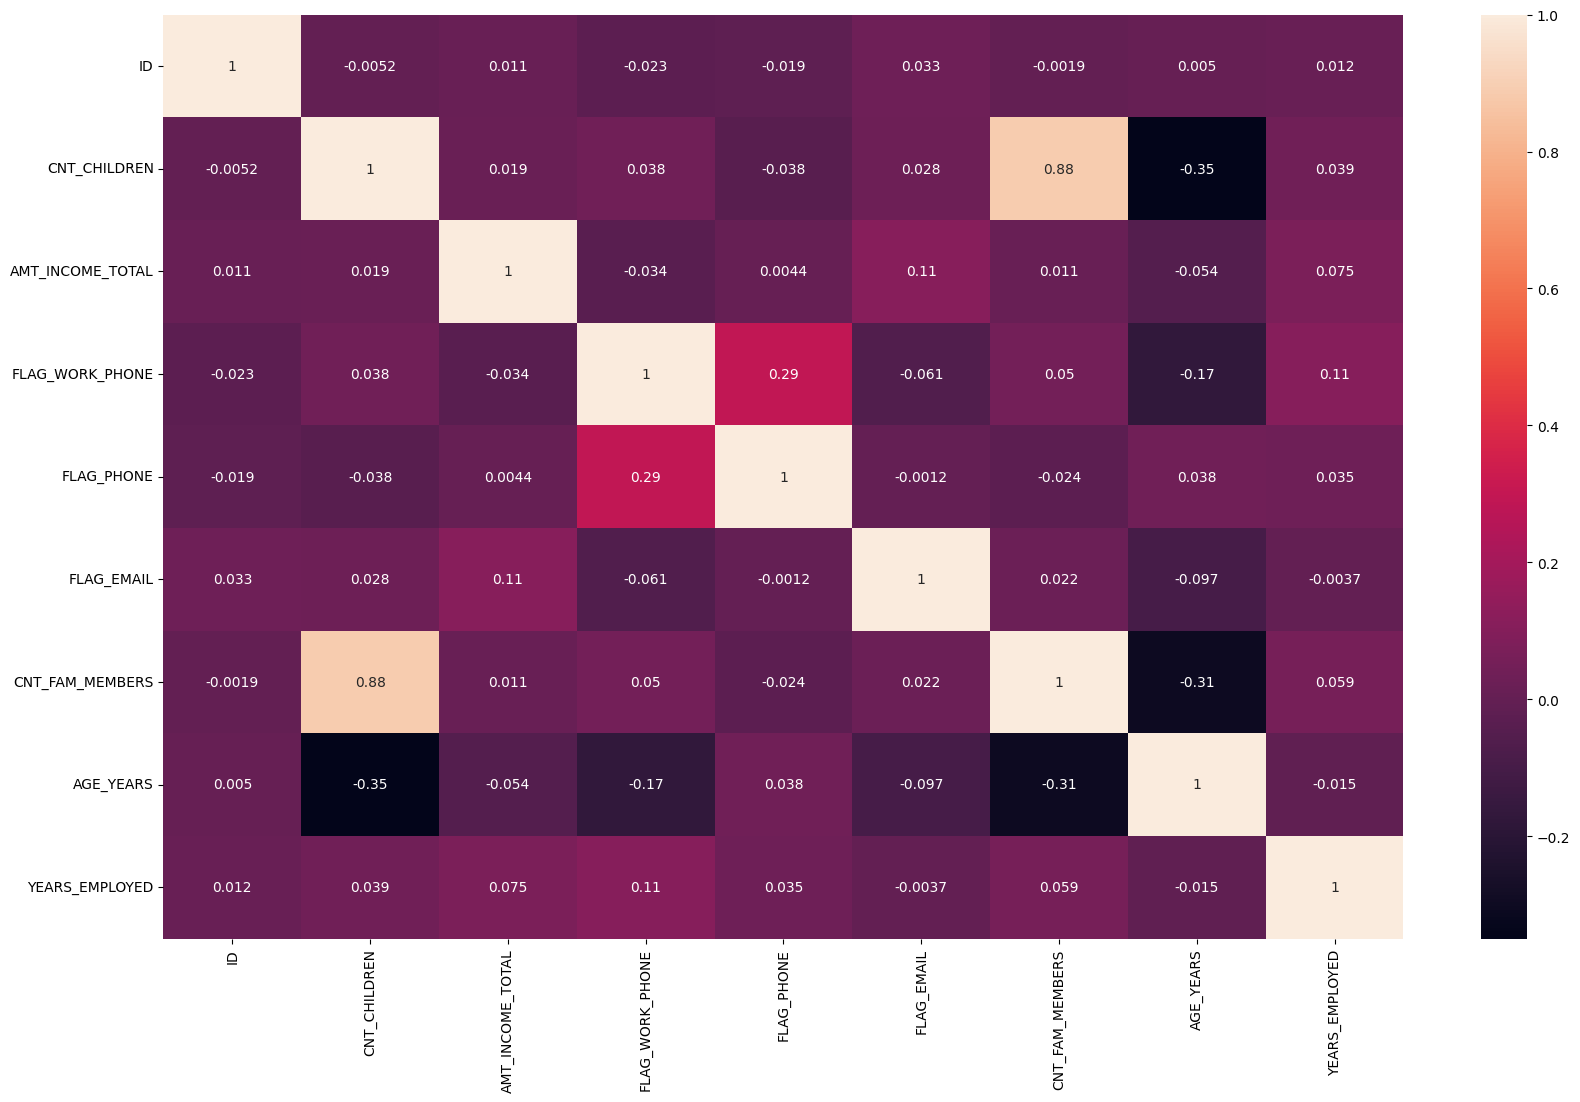

In [34]:
df1.drop(columns=["FLAG_MOBIL"],inplace=True)
corr = df1.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr, annot=True)
plt.show()

In [35]:
df2 = pd.read_csv('https://raw.githubusercontent.com/bhagyatrivedi/DSEM_dataset/main/credit_record.csv')

In [36]:
df2.head()

ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C

In [37]:
df2.shape

(1048575, 3)

In [38]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [39]:
df2.duplicated().sum()

0

In [40]:
df2['MONTHS_BALANCE'].unique()

array([  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12,
       -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25,
       -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38,
       -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51,
       -52, -53, -54, -55, -56, -57, -58, -59, -60])

In [41]:
df2['STATUS'].unique()

array(['X', '0', 'C', '1', '2', '3', '4', '5'], dtype=object)

In [42]:
df2[df2['STATUS'].isin(['X', 'C'])]

ID  MONTHS_BALANCE STATUS
0        5001711               0      X
4        5001712               0      C
5        5001712              -1      C
6        5001712              -2      C
7        5001712              -3      C
...          ...             ...    ...
1048570  5150487             -25      C
1048571  5150487             -26      C
1048572  5150487             -27      C
1048573  5150487             -28      C
1048574  5150487             -29      C

[651261 rows x 3 columns]

In [43]:
df2['ID'].nunique()

45985

In [44]:
df2['target']=df2['STATUS']
df2['target'].replace('X', 0, inplace=True)
df2['target'].replace('C', 0, inplace=True)
df2['target']=df2['target'].astype(int)
df2.loc[df2['target']>=1,'target']=1

In [45]:
df3=pd.DataFrame(df2.groupby(['ID'])['target'].agg("max")).reset_index()

In [46]:
df3["target"].value_counts()

0    40635
1     5350
Name: target, dtype: int64

In [47]:
df = pd.merge(df1, df3, how='inner', on=['ID'])

In [48]:
df

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0      5008804           M            Y               Y             0   
1      5008805           M            Y               Y             0   
2      5008806           M            Y               Y             0   
3      5008808           F            N               Y             0   
4      5008809           F            N               Y             0   
...        ...         ...          ...             ...           ...   
36452  5149828           M            Y               Y             0   
36453  5149834           F            N               Y             0   
36454  5149838           F            N               Y             0   
36455  5150049           F            N               Y             0   
36456  5150337           M            N               Y             0   

       AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              427500.0               Working               Higher education   
1              427500.0               Working               Higher education   
2              112500.0               Working  Secondary / secondary special   
3              270000.0  Commercial associate  Secondary / secondary special   
4              270000.0  Commercial associate  Secondary / secondary special   
...                 ...                   ...                            ...   
36452          315000.0               Working  Secondary / secondary special   
36453          157500.0  Commercial associate               Higher education   
36454          157500.0             Pensioner               Higher education   
36455          283500.0               Working  Secondary / secondary special   
36456          112500.0               Working  Secondary / secondary special   

         NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  FLAG_WORK_PHONE  FLAG_PHONE  \
0            Civil marriage   Rented apartment                1           0   
1            Civil marriage   Rented apartment                1           0   
2                   Married  House / apartment                0           0   
3      Single / not married  House / apartment                0           1   
4      Single / not married  House / apartment                0           1   
...                     ...                ...              ...         ...   
36452               Married  House / apartment                0           0   
36453               Married  House / apartment                0           1   
36454               Married  House / apartment                0           1   
36455               Married  House / apartment                0           0   
36456  Single / not married   Rented apartment                0           0   

       FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  AGE_YEARS  YEARS_EMPLOYED  \
0               0   not_specified              2.0       33.0            12.0   
1               0   not_specified              2.0       33.0            12.0   
2               0  Security staff              2.0       59.0             3.0   
3               1     Sales staff              1.0       52.0             8.0   
4               1     Sales staff              1.0       52.0             8.0   
...           ...             ...              ...        ...             ...   
36452           0        Managers              2.0       47.0             7.0   
36453           1  Medicine staff              2.0       34.0             4.0   
36454           1  Medicine staff              2.0       34.0             4.0   
36455           0     Sales staff              2.0       49.0             2.0   
36456           0        Laborers              1.0       25.0             3.0   

       target  
0           1  
1           1  
2           0  
3           0  
4           0  
...       ...  
36452       1  
36453       1  
36454       1  
36455       1  
36456       1  

[36457 rows x 18 columns]

In [49]:
start_df = pd.DataFrame(df2.groupby(['ID'])['MONTHS_BALANCE'].agg(min)).reset_index()

start_df.rename(columns={'MONTHS_BALANCE': 'ACCOUNT_LENGTH'}, inplace=True)

start_df['ACCOUNT_LENGTH'] = -start_df['ACCOUNT_LENGTH']

In [50]:
start_df

ID  ACCOUNT_LENGTH
0      5001711               3
1      5001712              18
2      5001713              21
3      5001714              14
4      5001715              59
...        ...             ...
45980  5150482              28
45981  5150483              17
45982  5150484              12
45983  5150485               1
45984  5150487              29

[45985 rows x 2 columns]

In [51]:
df = pd.merge(df, start_df, how='inner', on=['ID'])

In [52]:
df.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
AGE_YEARS              float64
YEARS_EMPLOYED         float64
target                   int64
ACCOUNT_LENGTH           int64
dtype: object

In [53]:
df.describe()

ID  CNT_CHILDREN  AMT_INCOME_TOTAL  FLAG_WORK_PHONE  \
count  3.645700e+04  36457.000000      3.645700e+04     36457.000000   
mean   5.078227e+06      0.430315      1.866857e+05         0.225526   
std    4.187524e+04      0.742367      1.017892e+05         0.417934   
min    5.008804e+06      0.000000      2.700000e+04         0.000000   
25%    5.042028e+06      0.000000      1.215000e+05         0.000000   
50%    5.074614e+06      0.000000      1.575000e+05         0.000000   
75%    5.115396e+06      1.000000      2.250000e+05         0.000000   
max    5.150487e+06     19.000000      1.575000e+06         1.000000   

         FLAG_PHONE    FLAG_EMAIL  CNT_FAM_MEMBERS     AGE_YEARS  \
count  36457.000000  36457.000000     36457.000000  36457.000000   
mean       0.294813      0.089722         2.198453     43.747017   
std        0.455965      0.285787         0.911686     11.514045   
min        0.000000      0.000000         1.000000     21.000000   
25%        0.000000      0.000000         2.000000     34.000000   
50%        0.000000      0.000000         2.000000     43.000000   
75%        1.000000      0.000000         3.000000     53.000000   
max        1.000000      1.000000        20.000000     69.000000   

       YEARS_EMPLOYED        target  ACCOUNT_LENGTH  
count    36457.000000  36457.000000    36457.000000  
mean         6.036783      0.117700       26.164193  
std          6.488058      0.322257       16.501854  
min          0.000000      0.000000        0.000000  
25%          1.000000      0.000000       12.000000  
50%          4.000000      0.000000       24.000000  
75%          9.000000      0.000000       39.000000  
max         43.000000      1.000000       60.000000

In [54]:
df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'AGE_YEARS', 'YEARS_EMPLOYED', 'target', 'ACCOUNT_LENGTH'],
      dtype='object')

In [55]:
df.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
AGE_YEARS              float64
YEARS_EMPLOYED         float64
target                   int64
ACCOUNT_LENGTH           int64
dtype: object

In [56]:
df.drop(columns=['ID', 'CNT_CHILDREN'], inplace=True)

## Applying Log Transformation


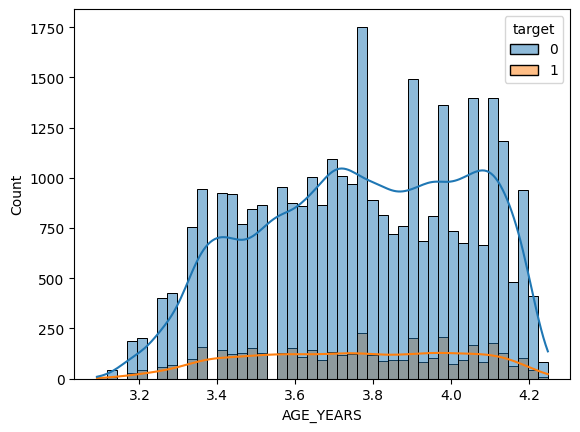

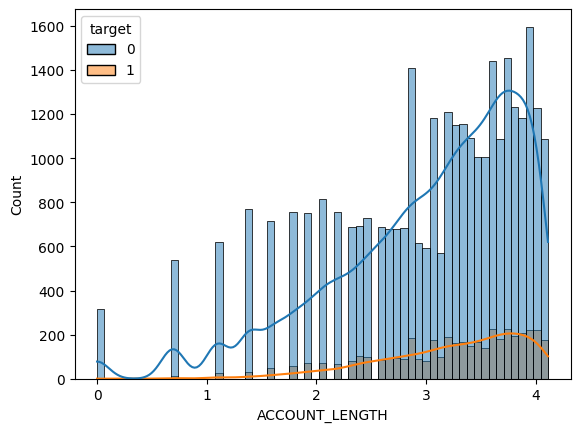

In [57]:
# create a list of columns for applying log transformations
log_list = ['AGE_YEARS','ACCOUNT_LENGTH']

# applying log transformation to the desired columns
for col in log_list:
  df[col] = np.log1p(df[col])

# plotting a histogram to verify the distribution
for col in log_list:
  sns.histplot(data=df,x=col,hue='target',kde=True)
  plt.show()

<ipython-input-58-b41e8f2749e8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cm = df.corr()


Text(0.5, 1.0, ' Correlation heatmap')

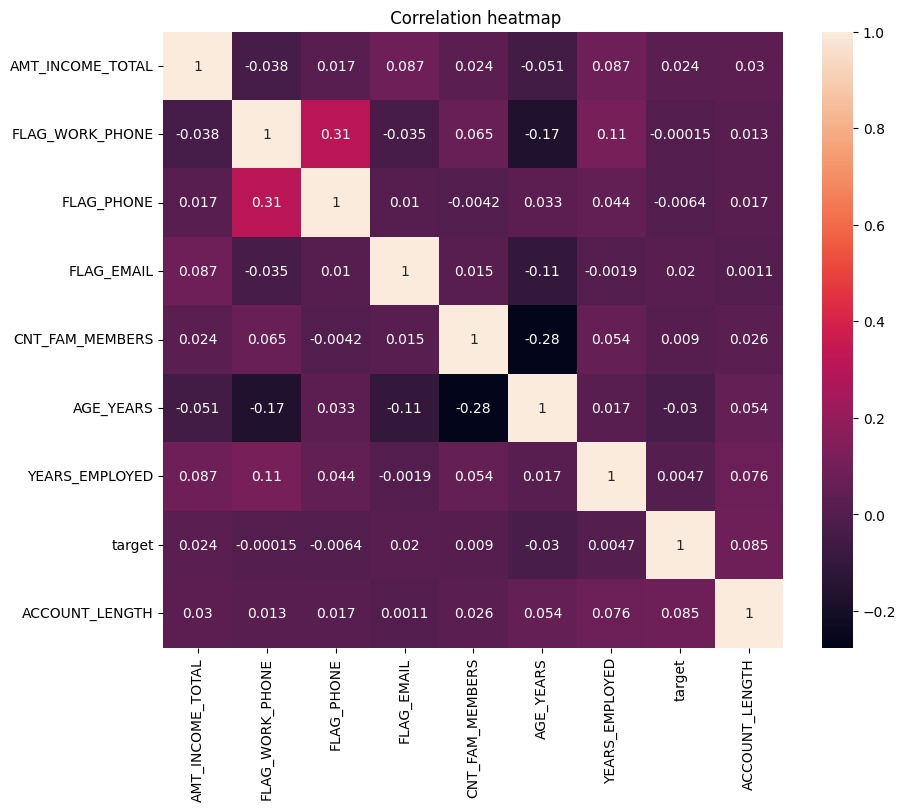

In [58]:
cm = df.corr()

# generating the heatmap from correlation matrix
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(cm, annot=True)
plt.title(" Correlation heatmap")


# ONE HOT ENCODING

In [59]:
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [60]:
columns_to_scale = ['AMT_INCOME_TOTAL', 'AGE_YEARS','YEARS_EMPLOYED', 'CNT_FAM_MEMBERS']

In [61]:
dummy = df.copy()

In [62]:
st=StandardScaler()
df[columns_to_scale] = st.fit_transform(df[columns_to_scale])

In [63]:
columns_to_encode = ['CODE_GENDER','FLAG_OWN_CAR','NAME_EDUCATION_TYPE', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE']
df=pd.get_dummies(df,columns=columns_to_encode,dtype='int')

In [64]:
df

AMT_INCOME_TOTAL  CNT_FAM_MEMBERS  AGE_YEARS  YEARS_EMPLOYED  target  \
0              2.365845        -0.217680  -0.908134        0.919119       1   
1              2.365845        -0.217680  -0.908134        0.919119       1   
2             -0.728827        -0.217680   1.237411       -0.468064       0   
3              0.818509        -1.314564   0.768805        0.302593       0   
4              0.818509        -1.314564   0.768805        0.302593       0   
...                 ...              ...        ...             ...     ...   
36452          1.260605        -0.217680   0.394492        0.148462       1   
36453         -0.286731        -0.217680  -0.798634       -0.313932       1   
36454         -0.286731        -0.217680  -0.798634       -0.313932       1   
36455          0.951138        -0.217680   0.548696       -0.622195       1   
36456         -0.728827        -1.314564  -1.921494       -0.468064       1   

       ACCOUNT_LENGTH  CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  \
0            2.772589              0              1               0   
1            2.708050              0              1               0   
2            3.401197              0              1               0   
3            1.609438              1              0               1   
4            3.295837              1              0               1   
...               ...            ...            ...             ...   
36452        2.484907              0              1               0   
36453        3.178054              1              0               1   
36454        3.496508              1              0               1   
36455        2.302585              1              0               1   
36456        2.639057              0              1               1   

       FLAG_OWN_CAR_Y  ...  OCCUPATION_TYPE_Low-skill Laborers  \
0                   1  ...                                   0   
1                   1  ...                                   0   
2                   1  ...                                   0   
3                   0  ...                                   0   
4                   0  ...                                   0   
...               ...  ...                                 ...   
36452               1  ...                                   0   
36453               0  ...                                   0   
36454               0  ...                                   0   
36455               0  ...                                   0   
36456               0  ...                                   0   

       OCCUPATION_TYPE_Managers  OCCUPATION_TYPE_Medicine staff  \
0                             0                               0   
1                             0                               0   
2                             0                               0   
3                             0                               0   
4                             0                               0   
...                         ...                             ...   
36452                         1                               0   
36453                         0                               1   
36454                         0                               1   
36455                         0                               0   
36456                         0                               0   

       OCCUPATION_TYPE_Private service staff  OCCUPATION_TYPE_Realty agents  \
0                                          0                              0   
1                                          0                              0   
2                                          0                              0   
3                                          0                              0   
4                                          0                              0   
...                                      ...                            ...   
36452                                      0          

In [65]:
df.describe()

AMT_INCOME_TOTAL  CNT_FAM_MEMBERS     AGE_YEARS  YEARS_EMPLOYED  \
count      3.645700e+04     3.645700e+04  3.645700e+04    3.645700e+04   
mean       1.559191e-18     2.424542e-16  3.130855e-15   -7.717994e-17   
std        1.000014e+00     1.000014e+00  1.000014e+00    1.000014e+00   
min       -1.568810e+00    -1.314564e+00 -2.552536e+00   -9.304580e-01   
25%       -6.404080e-01    -2.176798e-01 -7.986341e-01   -7.763266e-01   
50%       -2.867311e-01    -2.176798e-01  6.580885e-02   -3.139323e-01   
75%        3.764130e-01     8.792039e-01  8.394143e-01    4.567249e-01   
max        1.363930e+01     1.952623e+01  1.819711e+00    5.697194e+00   

             target  ACCOUNT_LENGTH  CODE_GENDER_F  CODE_GENDER_M  \
count  36457.000000    36457.000000   36457.000000   36457.000000   
mean       0.117700        3.031873       0.670105       0.329895   
std        0.322257        0.846592       0.470181       0.470181   
min        0.000000        0.000000       0.000000       0.000000   
25%        0.000000        2.564949       0.000000       0.000000   
50%        0.000000        3.218876       1.000000       0.000000   
75%        0.000000        3.688879       1.000000       1.000000   
max        1.000000        4.110874       1.000000       1.000000   

       FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  ...  \
count    36457.000000    36457.000000  ...   
mean         0.620292        0.379708  ...   
std          0.485321        0.485321  ...   
min          0.000000        0.000000  ...   
25%          0.000000        0.000000  ...   
50%          1.000000        0.000000  ...   
75%          1.000000        1.000000  ...   
max          1.000000        1.000000  ...   

       OCCUPATION_TYPE_Low-skill Laborers  OCCUPATION_TYPE_Managers  \
count                        36457.000000              36457.000000   
mean                             0.004800                  0.082618   
std                              0.069118                  0.275308   
min                              0.000000                  0.000000   
25%                              0.000000                  0.000000   
50%                              0.000000                  0.000000   
75%                              0.000000                  0.000000   
max                              1.000000                  1.000000   

       OCCUPATION_TYPE_Medicine staff  OCCUPATION_TYPE_Private service staff  \
count                    36457.000000                           36457.000000   
mean                         0.033107                               0.009436   
std                          0.178920                               0.096680   
min                          0.000000                               0.000000   
25%                          0.000000                               0.000000   
50%                          0.000000                               0.000000   
75%                          0.000000                               0.000000   
max                          1.000000                               1.000000   

       OCCUPATION_TYPE_Realty agents  OCCUPATION_TYPE_Sales staff  \
count                   36457.000000                 36457.000000   
mean                        0.002167                     0.095592   
std                         0.046501                     0.294035   
min                         0.000000                     0.000000   
25%                         0.000000                     0.000000   
50%                         0.000000                     0.000000   
75%                         0.000000                     0.000000   
max                         1.000000                     1.000000   

       OCCUPATION_TYPE_Secretaries  OCCUPATION_TYPE_Security staff  \
count                 36457.000000                    36457.000000   
mean                      0.004142                        0.016238   
std                       0.064225                        0.126392   
min                       0.000000      

In [66]:
df.corr()['target'].sort_values(ascending=False)

target                                               1.000000
ACCOUNT_LENGTH                                       0.085220
FLAG_OWN_REALTY_N                                    0.027990
AMT_INCOME_TOTAL                                     0.024202
CODE_GENDER_M                                        0.021257
FLAG_EMAIL_1                                         0.019658
NAME_EDUCATION_TYPE_Incomplete higher                0.018118
NAME_INCOME_TYPE_Commercial associate                0.016257
OCCUPATION_TYPE_Low-skill Laborers                   0.015274
OCCUPATION_TYPE_Security staff                       0.014359
NAME_FAMILY_STATUS_Single / not married              0.013716
OCCUPATION_TYPE_Core staff                           0.011522
OCCUPATION_TYPE_Managers                             0.010972
FLAG_OWN_CAR_N                                       0.010580
NAME_INCOME_TYPE_State servant                       0.010451
OCCUPATION_TYPE_Medicine staff                       0.009960
NAME_EDU

# Splitting the data into training and testing dataset

In [67]:
x= df.drop(['target'], axis=1)
y= df['target']

In [68]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [69]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: target, dtype: int64

# Linear model building using Logistic Regression

In [70]:
# fit Logistic Regression model to training data
logreg = LogisticRegression()
logreg.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [71]:
log_odds = logreg.coef_[0]
pd.DataFrame(log_odds,
             x_train.columns,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

coef
NAME_EDUCATION_TYPE_Academic degree                0.463278
ACCOUNT_LENGTH                                     0.372244
OCCUPATION_TYPE_Low-skill Laborers                 0.340426
OCCUPATION_TYPE_HR staff                           0.275351
OCCUPATION_TYPE_Security staff                     0.244246
OCCUPATION_TYPE_IT staff                           0.229307
NAME_HOUSING_TYPE_Office apartment                 0.131292
OCCUPATION_TYPE_Realty agents                      0.124114
OCCUPATION_TYPE_Cleaning staff                     0.099824
OCCUPATION_TYPE_Medicine staff                     0.081436
OCCUPATION_TYPE_High skill tech staff              0.070075
AMT_INCOME_TOTAL                                   0.060779
OCCUPATION_TYPE_Cooking staff                      0.043722
NAME_HOUSING_TYPE_Rented apartment                 0.022978
OCCUPATION_TYPE_Managers                           0.021227
CNT_FAM_MEMBERS                                    0.011298
OCCUPATION_TYPE_Core staff                         0.006018
YEARS_EMPLOYED                                    -0.003693
NAME_HOUSING_TYPE_Municipal apartment             -0.015821
NAME_INCOME_TYPE_Pensioner                        -0.034152
NAME_FAMILY_STATUS_Single / not married           -0.036016
OCCUPATION_TYPE_Accountants                       -0.038394
NAME_FAMILY_STATUS_Civil marriage                 -0.078544
AGE_YEARS                                         -0.088556
OCCUPATION_TYPE_Sales staff                       -0.096842
NAME_INCOME_TYPE_Student                          -0.100130
NAME_INCOME_TYPE_Commercial associate             -0.103971
NAME_FAMILY_STATUS_Widow                          -0.104650
OCCUPATION_TYPE_Drivers                           -0.109362
NAME_EDUCATION_TYPE_Incomplete higher             -0.113053
NAME_FAMILY_STATUS_Married                        -0.122526
NAME_HOUSING_TYPE_House / apartment               -0.127697
NAME_INCOME_TYPE_State servant                    -0.127920
OCCUPATION_TYPE_Laborers                          -0.134880
NAME_HOUSING_TYPE_With parents                    -0.136048
FLAG_OWN_CAR_N                                    -0.187542
NAME_INCOME_TYPE_Working                          -0.193013
FLAG_OWN_REALTY_N                                 -0.198456
CODE_GENDER_M                                     -0.202331
OCCUPATION_TYPE_not_specified                     -0.205727
FLAG_EMAIL_1                                      -0.216943
NAME_FAMILY_STATUS_Separated                      -0.217450
FLAG_WORK_PHONE_0                                 -0.222529
NAME_EDUCATION_TYPE_Secondary / secondary special -0.252096
OCCUPATION_TYPE_Waiters/barmen staff              -0.264333
FLAG_PHONE_0                                      -0.269705
FLAG_PHONE_1                                      -0.289481
NAME_EDUCATION_TYPE_Lower secondary               -0.326444
NAME_EDUCATION_TYPE_Higher education              -0.330870
FLAG_WORK_PHONE_1                                 -0.336657
FLAG_EMAIL_0                                      -0.342243
CODE_GENDER_F                                     -0.356855
FLAG_OWN_REALTY_Y                                 -0.360730
FLAG_OWN_CAR_Y                                    -0.371644
NAME_HOUSING_TYPE_Co-op apartment                 -0.433891
OCCUPATION_TYPE_Private service staff             -0.544486
OCCUPATION_TYPE_Secretaries                       -0.700907

## Converting the above log odd functions to regular odds:

In [72]:
odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds,
             x_train.columns,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

coef
NAME_EDUCATION_TYPE_Academic degree                1.589274
ACCOUNT_LENGTH                                     1.450987
OCCUPATION_TYPE_Low-skill Laborers                 1.405547
OCCUPATION_TYPE_HR staff                           1.316992
OCCUPATION_TYPE_Security staff                     1.276658
OCCUPATION_TYPE_IT staff                           1.257728
NAME_HOUSING_TYPE_Office apartment                 1.140301
OCCUPATION_TYPE_Realty agents                      1.132144
OCCUPATION_TYPE_Cleaning staff                     1.104976
OCCUPATION_TYPE_Medicine staff                     1.084844
OCCUPATION_TYPE_High skill tech staff              1.072588
AMT_INCOME_TOTAL                                   1.062664
OCCUPATION_TYPE_Cooking staff                      1.044692
NAME_HOUSING_TYPE_Rented apartment                 1.023244
OCCUPATION_TYPE_Managers                           1.021453
CNT_FAM_MEMBERS                                    1.011362
OCCUPATION_TYPE_Core staff                         1.006036
YEARS_EMPLOYED                                     0.996313
NAME_HOUSING_TYPE_Municipal apartment              0.984303
NAME_INCOME_TYPE_Pensioner                         0.966424
NAME_FAMILY_STATUS_Single / not married            0.964625
OCCUPATION_TYPE_Accountants                        0.962333
NAME_FAMILY_STATUS_Civil marriage                  0.924461
AGE_YEARS                                          0.915252
OCCUPATION_TYPE_Sales staff                        0.907699
NAME_INCOME_TYPE_Student                           0.904720
NAME_INCOME_TYPE_Commercial associate              0.901252
NAME_FAMILY_STATUS_Widow                           0.900640
OCCUPATION_TYPE_Drivers                            0.896406
NAME_EDUCATION_TYPE_Incomplete higher              0.893103
NAME_FAMILY_STATUS_Married                         0.884683
NAME_HOUSING_TYPE_House / apartment                0.880120
NAME_INCOME_TYPE_State servant                     0.879924
OCCUPATION_TYPE_Laborers                           0.873821
NAME_HOUSING_TYPE_With parents                     0.872801
FLAG_OWN_CAR_N                                     0.828994
NAME_INCOME_TYPE_Working                           0.824471
FLAG_OWN_REALTY_N                                  0.819996
CODE_GENDER_M                                      0.816824
OCCUPATION_TYPE_not_specified                      0.814056
FLAG_EMAIL_1                                       0.804976
NAME_FAMILY_STATUS_Separated                       0.804568
FLAG_WORK_PHONE_0                                  0.800492
NAME_EDUCATION_TYPE_Secondary / secondary special  0.777170
OCCUPATION_TYPE_Waiters/barmen staff               0.767718
FLAG_PHONE_0                                       0.763605
FLAG_PHONE_1                                       0.748652
NAME_EDUCATION_TYPE_Lower secondary                0.721485
NAME_EDUCATION_TYPE_Higher education               0.718298
FLAG_WORK_PHONE_1                                  0.714154
FLAG_EMAIL_0                                       0.710176
CODE_GENDER_F                                      0.699874
FLAG_OWN_REALTY_Y                                  0.697167
FLAG_OWN_CAR_Y                                     0.689600
NAME_HOUSING_TYPE_Co-op apartment                  0.647983
OCCUPATION_TYPE_Private service staff              0.580140
OCCUPATION_TYPE_Secretaries                        0.496135

## We see that there is a high data imbalance and it needs to be balanced. We will Handle the Imbalancing of data using SMOTE

# Handling data imbalance using SMOTE

In [73]:
col = list(df.columns)
type(col)
col.remove('target')

In [74]:
from sklearn.model_selection import train_test_split

# splitting the data into train and test in the ratio 70:30
X_trainr, X_testr,y_trainr,y_testr = train_test_split(x,y,test_size=0.3,random_state = 42)


In [75]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42,sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_trainr, y_trainr)

In [76]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_resampled,y_train_resampled)

# predicting test cases
y_pred = model.predict(X_testr)
print(y_pred)

[0 0 0 ... 0 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [77]:
from sklearn import metrics
print(metrics.classification_report(y_testr,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      9601
           1       0.13      0.04      0.06      1337

    accuracy                           0.85     10938
   macro avg       0.51      0.50      0.49     10938
weighted avg       0.79      0.85      0.81     10938



In [78]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_testr, y_pred)
print(conf_matrix)

[[9261  340]
 [1285   52]]


#Lets Fit Linear Model Again

In [79]:
# fit Logistic Regression model to training data
logreg = LogisticRegression()
logreg.fit(X_train_resampled,y_train_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [80]:
log_odds = logreg.coef_[0]
pd.DataFrame(log_odds,
             X_train_resampled.columns,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

coef
ACCOUNT_LENGTH                                     0.474268
AMT_INCOME_TOTAL                                   0.046048
YEARS_EMPLOYED                                    -0.003173
CNT_FAM_MEMBERS                                   -0.006122
AGE_YEARS                                         -0.064721
NAME_INCOME_TYPE_Student                          -1.041027
NAME_EDUCATION_TYPE_Academic degree               -1.542606
NAME_HOUSING_TYPE_Rented apartment                -2.083414
NAME_HOUSING_TYPE_House / apartment               -2.294432
NAME_HOUSING_TYPE_With parents                    -2.432320
NAME_HOUSING_TYPE_Co-op apartment                 -2.597828
FLAG_EMAIL_1                                      -2.667426
NAME_HOUSING_TYPE_Municipal apartment             -2.710342
FLAG_EMAIL_0                                      -2.775351
NAME_HOUSING_TYPE_Office apartment                -2.789289
NAME_INCOME_TYPE_Pensioner                        -2.991008
OCCUPATION_TYPE_IT staff                          -3.219703
FLAG_WORK_PHONE_0                                 -3.239810
FLAG_WORK_PHONE_1                                 -3.246428
CODE_GENDER_M                                     -3.267036
CODE_GENDER_F                                     -3.351377
NAME_EDUCATION_TYPE_Incomplete higher             -3.391067
NAME_EDUCATION_TYPE_Secondary / secondary special -3.419819
FLAG_OWN_REALTY_N                                 -3.500368
FLAG_OWN_CAR_N                                    -3.560435
FLAG_OWN_REALTY_Y                                 -3.608347
NAME_INCOME_TYPE_Working                          -3.616328
NAME_INCOME_TYPE_State servant                    -3.631843
NAME_INCOME_TYPE_Commercial associate             -3.645010
NAME_EDUCATION_TYPE_Higher education              -3.671039
FLAG_PHONE_0                                      -3.679326
FLAG_OWN_CAR_Y                                    -3.865882
FLAG_PHONE_1                                      -3.934920
NAME_FAMILY_STATUS_Married                        -4.001853
NAME_FAMILY_STATUS_Civil marriage                 -4.103572
NAME_FAMILY_STATUS_Single / not married           -4.159701
OCCUPATION_TYPE_Realty agents                     -4.170931
NAME_EDUCATION_TYPE_Lower secondary               -4.248876
NAME_FAMILY_STATUS_Widow                          -4.386535
NAME_FAMILY_STATUS_Separated                      -4.430439
OCCUPATION_TYPE_HR staff                          -4.580027
OCCUPATION_TYPE_Drivers                           -4.702851
OCCUPATION_TYPE_Cleaning staff                    -4.741406
OCCUPATION_TYPE_Accountants                       -4.828785
OCCUPATION_TYPE_Core staff                        -4.843020
OCCUPATION_TYPE_Low-skill Laborers                -4.878870
OCCUPATION_TYPE_Cooking staff                     -4.929853
OCCUPATION_TYPE_Managers                          -4.931529
OCCUPATION_TYPE_Sales staff                       -4.933618
OCCUPATION_TYPE_Laborers                          -4.936049
OCCUPATION_TYPE_Medicine staff                    -4.963431
OCCUPATION_TYPE_not_specified                     -5.084583
OCCUPATION_TYPE_High skill tech staff             -5.163415
OCCUPATION_TYPE_Security staff                    -5.255843
OCCUPATION_TYPE_Private service staff             -5.575810
OCCUPATION_TYPE_Waiters/barmen staff              -6.141262
OCCUPATION_TYPE_Secretaries                       -6.486060

In [81]:
odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds,
             X_train_resampled.columns,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

coef
ACCOUNT_LENGTH                                     1.606837
AMT_INCOME_TOTAL                                   1.047124
YEARS_EMPLOYED                                     0.996832
CNT_FAM_MEMBERS                                    0.993897
AGE_YEARS                                          0.937329
NAME_INCOME_TYPE_Student                           0.353092
NAME_EDUCATION_TYPE_Academic degree                0.213823
NAME_HOUSING_TYPE_Rented apartment                 0.124504
NAME_HOUSING_TYPE_House / apartment                0.100819
NAME_HOUSING_TYPE_With parents                     0.087833
NAME_HOUSING_TYPE_Co-op apartment                  0.074435
FLAG_EMAIL_1                                       0.069431
NAME_HOUSING_TYPE_Municipal apartment              0.066514
FLAG_EMAIL_0                                       0.062328
NAME_HOUSING_TYPE_Office apartment                 0.061465
NAME_INCOME_TYPE_Pensioner                         0.050237
OCCUPATION_TYPE_IT staff                           0.039967
FLAG_WORK_PHONE_0                                  0.039171
FLAG_WORK_PHONE_1                                  0.038913
CODE_GENDER_M                                      0.038119
CODE_GENDER_F                                      0.035036
NAME_EDUCATION_TYPE_Incomplete higher              0.033673
NAME_EDUCATION_TYPE_Secondary / secondary special  0.032718
FLAG_OWN_REALTY_N                                  0.030186
FLAG_OWN_CAR_N                                     0.028426
FLAG_OWN_REALTY_Y                                  0.027097
NAME_INCOME_TYPE_Working                           0.026881
NAME_INCOME_TYPE_State servant                     0.026467
NAME_INCOME_TYPE_Commercial associate              0.026121
NAME_EDUCATION_TYPE_Higher education               0.025450
FLAG_PHONE_0                                       0.025240
FLAG_OWN_CAR_Y                                     0.020944
FLAG_PHONE_1                                       0.019547
NAME_FAMILY_STATUS_Married                         0.018282
NAME_FAMILY_STATUS_Civil marriage                  0.016514
NAME_FAMILY_STATUS_Single / not married            0.015612
OCCUPATION_TYPE_Realty agents                      0.015438
NAME_EDUCATION_TYPE_Lower secondary                0.014280
NAME_FAMILY_STATUS_Widow                           0.012444
NAME_FAMILY_STATUS_Separated                       0.011909
OCCUPATION_TYPE_HR staff                           0.010255
OCCUPATION_TYPE_Drivers                            0.009069
OCCUPATION_TYPE_Cleaning staff                     0.008726
OCCUPATION_TYPE_Accountants                        0.007996
OCCUPATION_TYPE_Core staff                         0.007883
OCCUPATION_TYPE_Low-skill Laborers                 0.007606
OCCUPATION_TYPE_Cooking staff                      0.007228
OCCUPATION_TYPE_Managers                           0.007215
OCCUPATION_TYPE_Sales staff                        0.007200
OCCUPATION_TYPE_Laborers                           0.007183
OCCUPATION_TYPE_Medicine staff                     0.006989
OCCUPATION_TYPE_not_specified                      0.006191
OCCUPATION_TYPE_High skill tech staff              0.005722
OCCUPATION_TYPE_Security staff                     0.005217
OCCUPATION_TYPE_Private service staff              0.003788
OCCUPATION_TYPE_Waiters/barmen staff               0.002152
OCCUPATION_TYPE_Secretaries                        0.001525

Before applying SMOTE, the logistic regression analysis revealed specific patterns in how different features influenced the outcome. For example, features like `NAME_EDUCATION_TYPE_Academic degree` and `OCCUPATION_TYPE_HR staff` showed positive coefficients, indicating a positive relationship with the outcome variable. This suggests that individuals with higher education levels or certain occupations were more likely to experience the event of interest. Conversely, features like `NAME_EDUCATION_TYPE_Lower secondary` and `OCCUPATION_TYPE_Secretaries` had negative coefficients, implying a negative relationship with the outcome. This pattern indicates that certain demographic and professional characteristics were associated with lower likelihoods of the outcome. The variation in coefficients across different features provided insights into the factors that were positively or negatively associated with the outcome, highlighting the impact of educational background, occupation, and other personal attributes on the likelihood of experiencing the event of interest.

After applying SMOTE to address the class imbalance, there was a noticeable shift in the magnitude and direction of some coefficients, reflecting changes in the model's interpretation of the data. For instance, `ACCOUNT_LENGTH` showed an increased positive coefficient, suggesting a stronger relationship with the outcome post-SMOTE. This change implies that balancing the class distribution allowed the model to uncover more nuanced relationships between features and the outcome. Additionally, the dramatic changes in coefficients for variables like `OCCUPATION_TYPE_Waiters/barmen staff` and `NAME_HOUSING_TYPE_Co-op apartment` indicate that SMOTE not only affected the significance of individual predictors but also altered the model's overall understanding of how different factors contribute to the outcome. These shifts highlight the importance of addressing class imbalance in predictive modeling, as it can significantly influence the interpretation of model coefficients and, by extension, our understanding of the factors that drive the outcome of interest. The post-SMOTE analysis, therefore, provides a more balanced view, potentially leading to more accurate predictions and insights, especially regarding the minority class.

#### Q1 Fit a linear model and interpret the regression coefficients
#### ANS 1- After applying SMOTE and analyzing the post-SMOTE logistic regression coefficients, it's evident that features like `ACCOUNT_LENGTH` and specific occupations such as `IT staff` have gained importance, as indicated by their positive coefficients. For instance, `ACCOUNT_LENGTH` with a coefficient of 1.606837 suggests a significant positive relationship with the outcome, indicating that longer account lengths are associated with an increased likelihood of the event of interest. Conversely, features such as `OCCUPATION_TYPE_Private service staff` and `NAME_HOUSING_TYPE_Co-op apartment`, with coefficients of -5.575810 and -2.597828 respectively, illustrate a strong negative relationship, suggesting that individuals in private service roles or living in co-op apartments are less likely to experience the event of interest. These insights highlight the nuanced roles that specific professional and housing conditions play in influencing outcomes in the post-SMOTE analysis.
---



## Tree based model building using XGBoost.

In [82]:
xgb_cl = xgb.XGBClassifier(random_state=0)
xgb_cl.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [83]:
preds = xgb_cl.predict(x_test)
print(accuracy_score(y_test, preds))

0.8839824465167306


We're using the XGBoost classifier (xgb_cl) to make predictions on the test set (x_test) and then evaluating the accuracy of the predictions using the accuracy_score function.

The prediction accuracy is 88.76%.

### Fit the tree model and interpret the nodes-
## ANS 2
Fit a tree-based model and interpret the nodes
Ans: The plot below interprets all nodes (root, leaf, and intermediate) and displays the first tree plotted with the XGBoost algorithm. This figure shows how the model arrived at its final decisions and what splits it took to reach those results. As per the below plot, the root node is 'ACCOUNT_LENGTH'. Node interpretability for first 3 trees is shown below.

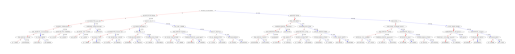

In [84]:
xgb.plot_tree(xgb_cl,num_trees=0)
plt.rcParams['figure.figsize'] = [500, 100]
plt.show()

### Second tree plotted with XGBoost algorithm.

In [85]:
xgb.plot_tree(xgb_cl,num_trees=1)
plt.rcParams['figure.figsize'] = [500, 100]
plt.show()

### Third tree plotted with XGBoost algorithm.

In [86]:
xgb.plot_tree(xgb_cl,num_trees=2)
plt.rcParams['figure.figsize'] = [500, 100]
plt.show()


## Using AutoML to find the best model.

In [87]:
pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 5.0 MB/s eta 0:00:00


In [88]:
# Import libraries
# Use pip install or conda install if missing a library
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
from h2o.estimators.random_forest import H2ORandomForestEstimator


In [89]:
# Set a minimum memory size and a run time in seconds
min_mem_size=6
run_time=222

In [90]:
# Use 50% of availible resources
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


This above code calculates the min_mem_size (minimum memory size) based on a percentage (pct_memory) of the available virtual memory on the system using the psutil library.

In [91]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:18324..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpp30ccnt0
  JVM stdout: /tmp/tmpp30ccnt0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpp30ccnt0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:18324
Connecting to H2O server at http://127.0.0.1:18324 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         06 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.1
H2O_cluster_version_age:    4 days
H2O_cluster_name:           H2O_from_python_unknownUser_efj84w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    5 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:18324
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

This above code snippet is attempting to start an H2O server with a randomly chosen port number in the range of 5555 to 55555 using the h2o.init function in Python. If an exception occurs during initialization, it logs the error, downloads all logs, shuts down the H2O cluster, and exits the script with a status code of 2.



In [92]:
df1 = h2o.import_file('https://raw.githubusercontent.com/bhagyatrivedi/DSEM_dataset/main/application_record.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [93]:
##Converting the H2O dataframe to Pandas DF
df1 = df1.as_data_frame()

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [94]:
df1.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  
0                2  
1                2  
2                2  
3                1  
4                1

In [95]:
df1.shape

(438557, 18)

In [96]:
df1 = df1.drop_duplicates(subset='ID',keep='first')

In [97]:
df1.shape

(438510, 18)

In [98]:
df1.columns[1:]

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

In [99]:
df1.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134193
CNT_FAM_MEMBERS             0
dtype: int64

In [100]:
df1.describe(percentiles=[.01,.02,.03,.04,.05,.1,.25,.5,.75,.9,.95,.96,.97,.98,.99]).T

count          mean            std        min  \
ID                438510.0  6.022035e+06  571496.239776  5008804.0   
CNT_CHILDREN      438510.0  4.273814e-01       0.724874        0.0   
AMT_INCOME_TOTAL  438510.0  1.875254e+05  110089.279583    26100.0   
DAYS_BIRTH        438510.0 -1.599802e+04    4185.016222   -25201.0   
DAYS_EMPLOYED     438510.0  6.056619e+04  138770.072835   -17531.0   
FLAG_MOBIL        438510.0  1.000000e+00       0.000000        1.0   
FLAG_WORK_PHONE   438510.0  2.061276e-01       0.404524        0.0   
FLAG_PHONE        438510.0  2.877699e-01       0.452724        0.0   
FLAG_EMAIL        438510.0  1.082005e-01       0.310634        0.0   
CNT_FAM_MEMBERS   438510.0  2.194463e+00       0.897192        1.0   

                          1%          2%          3%          4%          5%  \
ID                5024429.09  5041533.18  5054216.27  5068686.36  5091807.45   
CNT_CHILDREN            0.00        0.00        0.00        0.00        0.00   
AMT_INCOME_TOTAL    54000.00    67500.00    67500.00    72000.00    76500.00   
DAYS_BIRTH         -24013.00   -23642.00   -23413.00   -23181.00   -22972.00   
DAYS_EMPLOYED      -10913.00    -9533.00    -8486.00    -7792.00    -7205.00   
FLAG_MOBIL              1.00        1.00        1.00        1.00        1.00   
FLAG_WORK_PHONE         0.00        0.00        0.00        0.00        0.00   
FLAG_PHONE              0.00        0.00        0.00        0.00        0.00   
FLAG_EMAIL              0.00        0.00        0.00        0.00        0.00   
CNT_FAM_MEMBERS         1.00        1.00        1.00        1.00        1.00   

                        10%         25%         50%         75%        90%  \
ID                5181098.9  5609362.25  6047719.50  6454160.75  6722537.1   
CNT_CHILDREN            0.0        0.00        0.00        1.00        2.0   
AMT_INCOME_TOTAL    90000.0   121500.00   160940.25   225000.00   315000.0   
DAYS_BIRTH         -21982.0   -19484.00   -15630.00   -12514.00   -10519.0   
DAYS_EMPLOYED       -5295.0    -3103.00    -1467.00     -371.00   365243.0   
FLAG_MOBIL              1.0        1.00        1.00        1.00        1.0   
FLAG_WORK_PHONE         0.0        0.00        0.00        0.00        1.0   
FLAG_PHONE              0.0        0.00        0.00        1.00        1.0   
FLAG_EMAIL              0.0        0.00        0.00        0.00        1.0   
CNT_FAM_MEMBERS         1.0        2.00        2.00        3.00        3.0   

                         95%         96%        97%         98%         99%  \
ID                6800362.55  6830288.64  7009897.1  7271099.44  7636888.19   
CNT_CHILDREN            2.00        2.00        2.0        2.00        3.00   
AMT_INCOME_TOTAL   360000.00   382500.00   405000.0   450000.00   540000.00   
DAYS_BIRTH          -9889.00    -9655.00    -9343.0    -9011.00    -8575.00   
DAYS_EMPLOYED      365243.00   365243.00   365243.0   365243.00   365243.00   
FLAG_MOBIL              1.00        1.00        1.0        1.00        1.00   
FLAG_WORK_PHONE         1.00        1.00        1.0        1.00        1.00   
FLAG_PHONE              1.00        1.00        1.0        1.00        1.00   
FLAG_EMAIL              1.00        1.00        1.0        1.00        1.00   
CNT_FAM_MEMBERS         4.00        4.00        4.0        4.00        5.00   

                        max  
ID                7999952.0  
CNT_CHILDREN           19.0  
AMT_INCOME_TOTAL  6750000.0  
DAYS_BIRTH          -7489.0  
DAYS_EMPLOYED      365243.0  
FLAG_MOBIL              1.0  
FLAG_WORK_PHONE         1.0  
FLAG_PHONE              1.0  
FLAG_EMAIL              1.0  
CNT_FAM_MEMBERS        20.0

In [101]:
df1['DAYS_EMPLOYED'].replace(365243,0,inplace=True)

In [102]:
df1['AGE_YEARS']=round(-df1['DAYS_BIRTH']/365.2425,0)

In [103]:
df1['YEARS_EMPLOYED']=round(-df1['DAYS_EMPLOYED']/365.2425)
df1.loc[df1['YEARS_EMPLOYED']<0,'YEARS_EMPLOYED']=0

In [104]:
df1['OCCUPATION_TYPE'].fillna('not_specified',inplace=True)

In [105]:
df1.drop(columns=["DAYS_BIRTH","DAYS_EMPLOYED"],inplace=True)

In [106]:
df1.describe(percentiles=[.01,.02,.03,.04,.05,.1,.25,.5,.75,.9,.95,.96,.97,.98,.99]).T

count          mean            std        min  \
ID                438510.0  6.022035e+06  571496.239776  5008804.0   
CNT_CHILDREN      438510.0  4.273814e-01       0.724874        0.0   
AMT_INCOME_TOTAL  438510.0  1.875254e+05  110089.279583    26100.0   
FLAG_MOBIL        438510.0  1.000000e+00       0.000000        1.0   
FLAG_WORK_PHONE   438510.0  2.061276e-01       0.404524        0.0   
FLAG_PHONE        438510.0  2.877699e-01       0.452724        0.0   
FLAG_EMAIL        438510.0  1.082005e-01       0.310634        0.0   
CNT_FAM_MEMBERS   438510.0  2.194463e+00       0.897192        1.0   
AGE_YEARS         438510.0  4.380453e+01      11.465521       21.0   
YEARS_EMPLOYED    438510.0  5.956069e+00       6.574244        0.0   

                          1%          2%          3%          4%          5%  \
ID                5024429.09  5041533.18  5054216.27  5068686.36  5091807.45   
CNT_CHILDREN            0.00        0.00        0.00        0.00        0.00   
AMT_INCOME_TOTAL    54000.00    67500.00    67500.00    72000.00    76500.00   
FLAG_MOBIL              1.00        1.00        1.00        1.00        1.00   
FLAG_WORK_PHONE         0.00        0.00        0.00        0.00        0.00   
FLAG_PHONE              0.00        0.00        0.00        0.00        0.00   
FLAG_EMAIL              0.00        0.00        0.00        0.00        0.00   
CNT_FAM_MEMBERS         1.00        1.00        1.00        1.00        1.00   
AGE_YEARS              23.00       25.00       26.00       26.00       27.00   
YEARS_EMPLOYED          0.00        0.00        0.00        0.00        0.00   

                        10%         25%         50%         75%        90%  \
ID                5181098.9  5609362.25  6047719.50  6454160.75  6722537.1   
CNT_CHILDREN            0.0        0.00        0.00        1.00        2.0   
AMT_INCOME_TOTAL    90000.0   121500.00   160940.25   225000.00   315000.0   
FLAG_MOBIL              1.0        1.00        1.00        1.00        1.0   
FLAG_WORK_PHONE         0.0        0.00        0.00        0.00        1.0   
FLAG_PHONE              0.0        0.00        0.00        1.00        1.0   
FLAG_EMAIL              0.0        0.00        0.00        0.00        1.0   
CNT_FAM_MEMBERS         1.0        2.00        2.00        3.00        3.0   
AGE_YEARS              29.0       34.00       43.00       53.00       60.0   
YEARS_EMPLOYED          0.0        1.00        4.00        8.00       14.0   

                         95%         96%        97%         98%         99%  \
ID                6800362.55  6830288.64  7009897.1  7271099.44  7636888.19   
CNT_CHILDREN            2.00        2.00        2.0        2.00        3.00   
AMT_INCOME_TOTAL   360000.00   382500.00   405000.0   450000.00   540000.00   
FLAG_MOBIL              1.00        1.00        1.0        1.00        1.00   
FLAG_WORK_PHONE         1.00        1.00        1.0        1.00        1.00   
FLAG_PHONE              1.00        1.00        1.0        1.00        1.00   
FLAG_EMAIL              1.00        1.00        1.0        1.00        1.00   
CNT_FAM_MEMBERS         4.00        4.00        4.0        4.00        5.00   
AGE_YEARS              63.00       63.00       64.0       65.00       66.00   
YEARS_EMPLOYED         20.00       21.00       23.0       26.00       30.00   

                        max  
ID                7999952.0  
CNT_CHILDREN           19.0  
AMT_INCOME_TOTAL  6750000.0  
FLAG_MOBIL              1.0  
FLAG_WORK_PHONE         1.0  
FLAG_PHONE              1.0  
FLAG_EMAIL              1.0  
CNT_FAM_MEMBERS        20.0  
AGE_YEARS              69.0  
YEARS_EMPLOYED         48.0

In [107]:
df1['ID'].duplicated().sum()

0

In [108]:
df1.drop(columns=["FLAG_MOBIL"],inplace=True)

In [109]:
df2 = h2o.import_file('https://raw.githubusercontent.com/bhagyatrivedi/DSEM_dataset/main/credit_record.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [110]:
df2 = df2.as_data_frame()

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [111]:
df2.shape

(1048575, 3)

In [112]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [113]:
df2.duplicated().sum()

0

In [114]:
df2[df2['STATUS'].isin(['X', 'C'])]

ID  MONTHS_BALANCE STATUS
0        5001711               0      X
4        5001712               0      C
5        5001712              -1      C
6        5001712              -2      C
7        5001712              -3      C
...          ...             ...    ...
1048570  5150487             -25      C
1048571  5150487             -26      C
1048572  5150487             -27      C
1048573  5150487             -28      C
1048574  5150487             -29      C

[651261 rows x 3 columns]

In [115]:
df2['target']=df2['STATUS']
df2['target'].replace('X', 0, inplace=True)
df2['target'].replace('C', 0, inplace=True)
df2['target']=df2['target'].astype(int)
df2.loc[df2['target']>=1,'target']=1

In [116]:
df3=pd.DataFrame(df2.groupby(['ID'])['target'].agg("max")).reset_index()

In [117]:
df3["target"].value_counts()

0    40635
1     5350
Name: target, dtype: int64

In [118]:
df = pd.merge(df1, df3, how='inner', on=['ID'])

In [119]:
start_df = pd.DataFrame(df2.groupby(['ID'])['MONTHS_BALANCE'].agg(min)).reset_index()

start_df.rename(columns={'MONTHS_BALANCE': 'ACCOUNT_LENGTH'}, inplace=True)

start_df['ACCOUNT_LENGTH'] = -start_df['ACCOUNT_LENGTH']

In [120]:
df = pd.merge(df, start_df, how='inner', on=['ID'])

In [121]:
df.drop(columns=['ID', 'CNT_CHILDREN'], inplace=True)

<ipython-input-122-beba7af7f145>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


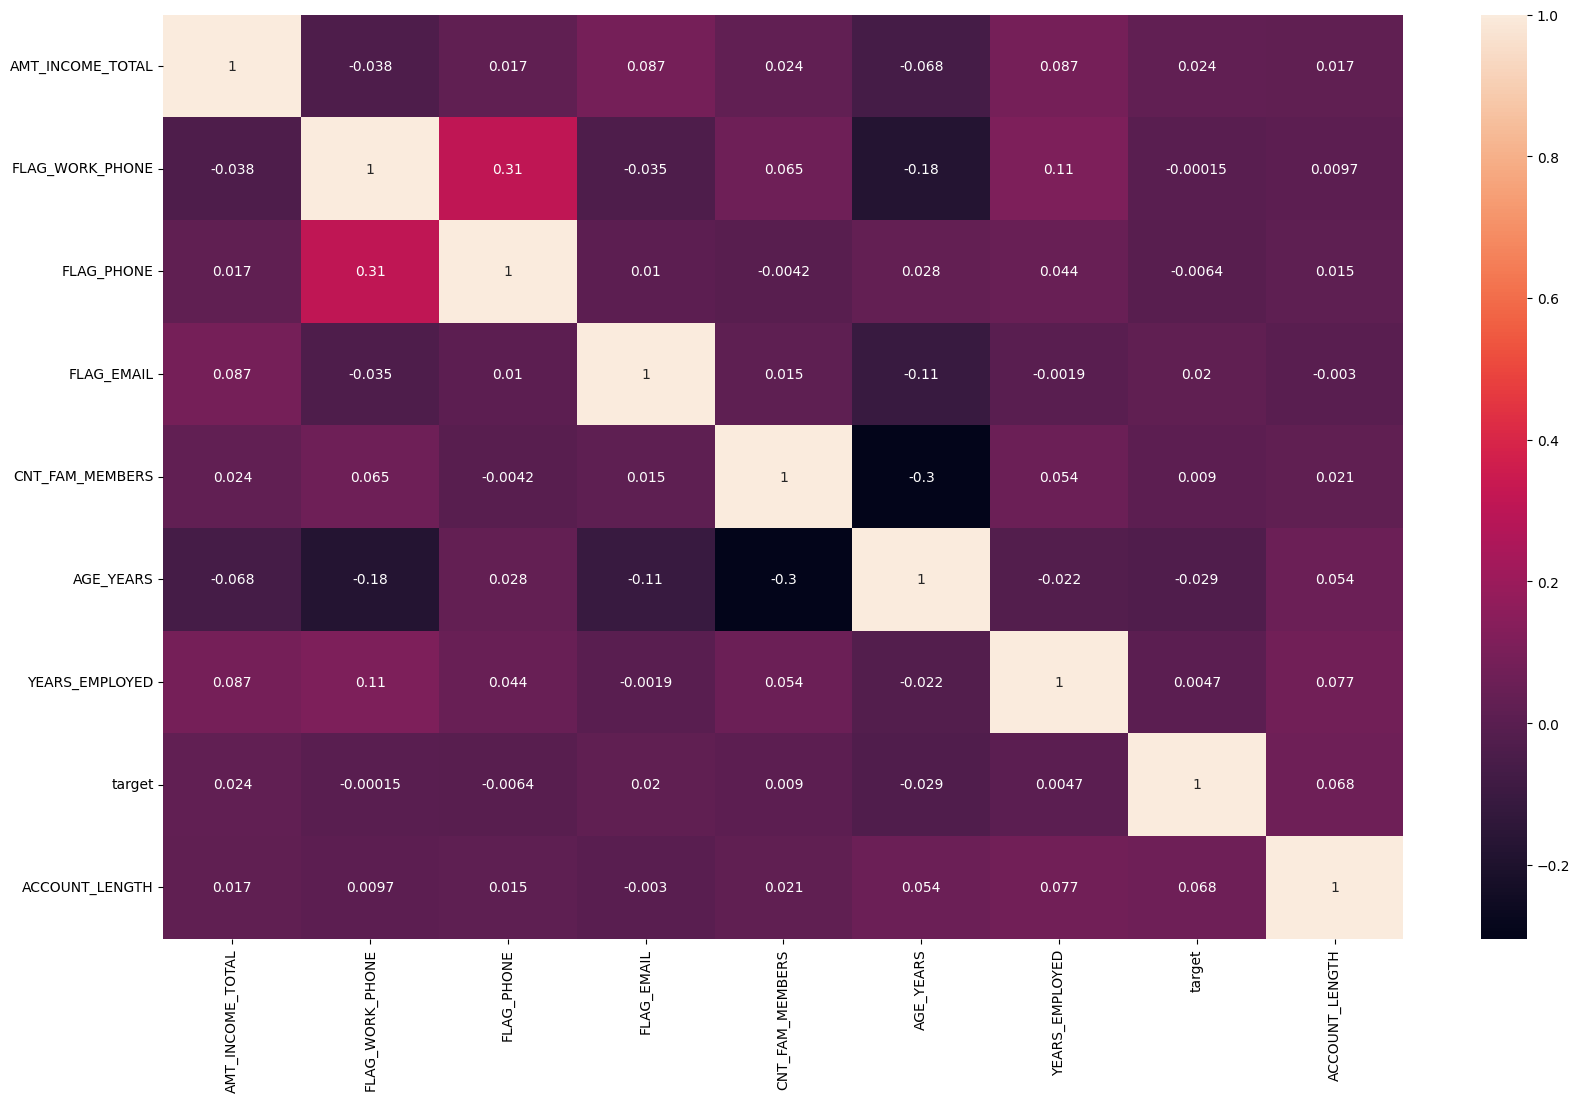

In [122]:
corr = df.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr, annot=True)
plt.show()

In [123]:
!pip install imbalanced-learn scikit-learn

In [124]:
columns_to_scale = ['AMT_INCOME_TOTAL', 'AGE_YEARS','YEARS_EMPLOYED', 'CNT_FAM_MEMBERS']

In [125]:
dummy = df.copy()

In [126]:
st=StandardScaler()
df[columns_to_scale] = st.fit_transform(df[columns_to_scale])

In [127]:
columns_to_encode = ['CODE_GENDER','FLAG_OWN_CAR','NAME_EDUCATION_TYPE', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE']
df=pd.get_dummies(df,columns=columns_to_encode,dtype='int')

In [128]:
# Convert back to H2OFrame
df = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [129]:
# set this to True if interactive (matplotlib) plots are desired
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt

In [130]:
# Data exploration and munging. Generate scatter plots
data = df
def scatter_plot(data, x, y, max_points = 1000, fit = True):
    if(fit):
        lr = H2OGeneralizedLinearEstimator(family = "gaussian")
        lr.train(x=x, y=y, training_frame=data)
        coeff = lr.coef()
    df = data[[x,y]]
    runif = df[y].runif()
    df_subset = df[runif < float(max_points)/data.nrow]
    df_py = h2o.as_list(df_subset)

    if(fit): h2o.remove(lr._id)

    # If x variable is string, generate box-and-whisker plot
    if(df_py[x].dtype == "object"):
        if interactive: df_py.boxplot(column = y, by = x)
    # Otherwise, generate a scatter plot
    else:
        if interactive: df_py.plot(x = x, y = y, kind = "scatter")

    if(fit):
        x_min = min(df_py[x])
        x_max = max(df_py[x])
        y_min = coeff["Intercept"] + coeff[x]*x_min
        y_max = coeff["Intercept"] + coeff[x]*x_max
        plt.plot([x_min, x_max], [y_min, y_max], "k-")
    if interactive: plt.show()

In [131]:
data.describe()

Rows:36457
Cols:58

AMT_INCOME_TOTAL         CNT_FAM_MEMBERS        AGE_YEARS               YEARS_EMPLOYED          target               ACCOUNT_LENGTH      CODE_GENDER_F        CODE_GENDER_M        FLAG_OWN_CAR_N      FLAG_OWN_CAR_Y      NAME_EDUCATION_TYPE_Academic degree    NAME_EDUCATION_TYPE_Higher education    NAME_EDUCATION_TYPE_Incomplete higher    NAME_EDUCATION_TYPE_Lower secondary    NAME_EDUCATION_TYPE_Secondary / secondary special    FLAG_OWN_REALTY_N    FLAG_OWN_REALTY_Y    NAME_INCOME_TYPE_Commercial associate    NAME_INCOME_TYPE_Pensioner    NAME_INCOME_TYPE_State servant    NAME_INCOME_TYPE_Student    NAME_INCOME_TYPE_Working    NAME_FAMILY_STATUS_Civil marriage    NAME_FAMILY_STATUS_Married    NAME_FAMILY_STATUS_Separated    NAME_FAMILY_STATUS_Single / not married    NAME_FAMILY_STATUS_Widow    NAME_HOUSING_TYPE_Co-op apartment    NAME_HOUSING_TYPE_House / apartment    NAME_HOUSING_TYPE_Municipal apartment    NAME_HOUSING_TYPE_Office apartment    NAME_HOUSING_TYPE_Rented apartment    NAME_HOUSING_TYPE_With parents    FLAG_WORK_PHONE_0    FLAG_WORK_PHONE_1    FLAG_PHONE_0         FLAG_PHONE_1         FLAG_EMAIL_0         FLAG_EMAIL_1         OCCUPATION_TYPE_Accountants    OCCUPATION_TYPE_Cleaning staff    OCCUPATION_TYPE_Cooking staff    OCCUPATION_TYPE_Core staff    OCCUPATION_TYPE_Drivers    OCCUPATION_TYPE_HR staff    OCCUPATION_TYPE_High skill tech staff    OCCUPATION_TYPE_IT staff    OCCUPATION_TYPE_Laborers    OCCUPATION_TYPE_Low-skill Laborers    OCCUPATION_TYPE_Managers    OCCUPATION_TYPE_Medicine staff    OCCUPATION_TYPE_Private service staff    OCCUPATION_TYPE_Realty agents    OCCUPATION_TYPE_Sales staff    OCCUPATION_TYPE_Secretaries    OCCUPATION_TYPE_Security staff    OCCUPATION_TYPE_Waiters/barmen staff    OCCUPATION_TYPE_not_specified
-------  -----------------------  ---------------------  ----------------------  ----------------------  -------------------  ------------------  -------------------  -------------------  ------------------  ------------------  -------------------------------------  --------------------------------------  ---------------------------------------  -------------------------------------  ---------------------------------------------------  -------------------  -------------------  ---------------------------------------  ----------------------------  --------------------------------  --------------------------  --------------------------  -----------------------------------  ----------------------------  ------------------------------  -----------------------------------------  --------------------------  -----------------------------------  -------------------------------------  ---------------------------------------  ------------------------------------  ------------------------------------  --------------------------------  -------------------  -------------------  -------------------  -------------------  -------------------  -------------------  -----------------------------  --------------------------------  -------------------------------  ----------------------------  -------------------------  --------------------------  ---------------------------------------  --------------------------  --------------------------  ------------------------------------  --------------------------  --------------------------------  ---------------------------------------  -------------------------------  -----------------------------  -----------------------------  --------------------------------  --------------------------------------  -------------------------------
type     real                     real                   real                    real                    int                  int                 int                  int                  int                 int                 int                                    int                                     int                                      int                                    int                                             

In [132]:
data['target'] = data['target'].asfactor()
print(data['target'].isfactor())

[True]


In [133]:
# Create a 80/20 train/test split
pct_rows=0.80
data_train, data_test = data.split_frame([pct_rows])

In [134]:
print(data_train.shape)
print(data_test.shape)

(29291, 58)
(7166, 58)


In [135]:
data_train.head(2)

AMT_INCOME_TOTAL    CNT_FAM_MEMBERS    AGE_YEARS    YEARS_EMPLOYED    target    ACCOUNT_LENGTH    CODE_GENDER_F    CODE_GENDER_M    FLAG_OWN_CAR_N    FLAG_OWN_CAR_Y    NAME_EDUCATION_TYPE_Academic degree    NAME_EDUCATION_TYPE_Higher education    NAME_EDUCATION_TYPE_Incomplete higher    NAME_EDUCATION_TYPE_Lower secondary    NAME_EDUCATION_TYPE_Secondary / secondary special    FLAG_OWN_REALTY_N    FLAG_OWN_REALTY_Y    NAME_INCOME_TYPE_Commercial associate    NAME_INCOME_TYPE_Pensioner    NAME_INCOME_TYPE_State servant    NAME_INCOME_TYPE_Student    NAME_INCOME_TYPE_Working    NAME_FAMILY_STATUS_Civil marriage    NAME_FAMILY_STATUS_Married    NAME_FAMILY_STATUS_Separated    NAME_FAMILY_STATUS_Single / not married    NAME_FAMILY_STATUS_Widow    NAME_HOUSING_TYPE_Co-op apartment    NAME_HOUSING_TYPE_House / apartment    NAME_HOUSING_TYPE_Municipal apartment    NAME_HOUSING_TYPE_Office apartment    NAME_HOUSING_TYPE_Rented apartment    NAME_HOUSING_TYPE_With parents    FLAG_WORK_PHONE_0    FLAG_WORK_PHONE_1    FLAG_PHONE_0    FLAG_PHONE_1    FLAG_EMAIL_0    FLAG_EMAIL_1    OCCUPATION_TYPE_Accountants    OCCUPATION_TYPE_Cleaning staff    OCCUPATION_TYPE_Cooking staff    OCCUPATION_TYPE_Core staff    OCCUPATION_TYPE_Drivers    OCCUPATION_TYPE_HR staff    OCCUPATION_TYPE_High skill tech staff    OCCUPATION_TYPE_IT staff    OCCUPATION_TYPE_Laborers    OCCUPATION_TYPE_Low-skill Laborers    OCCUPATION_TYPE_Managers    OCCUPATION_TYPE_Medicine staff    OCCUPATION_TYPE_Private service staff    OCCUPATION_TYPE_Realty agents    OCCUPATION_TYPE_Sales staff    OCCUPATION_TYPE_Secretaries    OCCUPATION_TYPE_Security staff    OCCUPATION_TYPE_Waiters/barmen staff    OCCUPATION_TYPE_not_specified
------------------  -----------------  -----------  ----------------  --------  ----------------  ---------------  ---------------  ----------------  ----------------  -------------------------------------  --------------------------------------  ---------------------------------------  -------------------------------------  ---------------------------------------------------  -------------------  -------------------  ---------------------------------------  ----------------------------  --------------------------------  --------------------------  --------------------------  -----------------------------------  ----------------------------  ------------------------------  -----------------------------------------  --------------------------  -----------------------------------  -------------------------------------  ---------------------------------------  ------------------------------------  ------------------------------------  --------------------------------  -------------------  -------------------  --------------  --------------  --------------  --------------  -----------------------------  --------------------------------  -------------------------------  ----------------------------  -------------------------  --------------------------  ---------------------------------------  --------------------------  --------------------------  ------------------------------------  --------------------------  --------------------------------  ---------------------------------------  -------------------------------  -----------------------------  -----------------------------  --------------------------------  --------------------------------------  -------------------------------
           2.36585           -0.21768    -0.933396          0.919119         1                15                0                1                 0                 1                                      0                                       1                                        0                                      0                                                    0                    0                    1                                        0                             0                                 0                           0                           1     

In [136]:
X=data.columns
print(X)

['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS', 'AGE_YEARS', 'YEARS_EMPLOYED', 'target', 'ACCOUNT_LENGTH', 'CODE_GENDER_F', 'CODE_GENDER_M', 'FLAG_OWN_CAR_N', 'FLAG_OWN_CAR_Y', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'FLAG_OWN_REALTY_N', 'FLAG_OWN_REALTY_Y', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Working', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_Office apartment', 'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents', 'FLAG_WORK_PHONE_0'

In [137]:
# Set target and predictor variables
y ='target'
#y_numeric ='churn_bit'
X.remove(y)
#X.remove(y_numeric)
print(X)

['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS', 'AGE_YEARS', 'YEARS_EMPLOYED', 'ACCOUNT_LENGTH', 'CODE_GENDER_F', 'CODE_GENDER_M', 'FLAG_OWN_CAR_N', 'FLAG_OWN_CAR_Y', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'FLAG_OWN_REALTY_N', 'FLAG_OWN_REALTY_Y', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Working', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_Office apartment', 'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents', 'FLAG_WORK_PHONE_0', 'FLAG_WO

In [138]:
# Set up AutoML
auml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [139]:
auml.train(x=X,y=y,training_frame=data_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20240318_31809


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  --------
Stacking strategy                          blending
Number of base models (used / total)       7/21
# GBM base models (used / total)           3/9
# XGBoost base models (used / total)       2/7
# DRF base models (used / total)           1/2
# GLM base models (used / total)           0/1
# DeepLearning base models (used / total)  1/2
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         AUTO
Metalearner nfolds                         0
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.047786451376454035
RMSE: 0.21860112391397724
LogLoss: 0.17884486187063456
AUC: 0.9900493561891772
AUCPR: 0.9274098624118546
Gini: 0.9800987123783544
Null degrees of freedom: 10061
Residual degrees of freedom: 10054
Null deviance: 7339.202996475311
Residual deviance: 3599.07400028465
AIC: 3615.07400028465

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24998544738612935
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      8624  242   0.0273   (242.0/8866.0)
1      108   1088  0.0903   (108.0/1196.0)
Total  8732  1330  0.0348   (350.0/10062.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.249985     0.861441  187
max f2                       0.216157     0.906414  201
max f0point5                 0.331128     0.868189  153
max accuracy                 0.26426      0.966011  181
max precision                0.999999     1         0
max recall                   0.115799     1         262
max specificity              0.999999     1         0
max absolute_mcc             0.249985     0.843168  187
max min_per_class_accuracy   0.211546     0.95635   203
max mean_per_class_accuracy  0.189202     0.957419  214
max tns                      0.999999     8866      0
max fns                      0.999999     1194      0
max fps                      2.37391e-06  8866      399
max tps                      0.115799     1196      262
max tnr                      0.999999     1         0
max fnr                      0.999999     0.998328  0
max fpr                      2.37391e-06  1         399
max tpr                      0.115799     1         262

Gains/Lift Table: Avg response rate: 11.89 %, avg score: 12.54 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100378                   0.7049             8.32975   8.32975            0.990099         0.781535   0.990099                    0.781535            0.083612        0.083612                   732.975   732.975            0.0834992
2        0.0200755                   0.626675           8.41304   8.37139            1                0.659608   0.99505                     0.720572            0.0844482       0.16806                    741.304   737.139            0.167947
3        0.0300139                   0.564532           8.32891   8.35733            0.99             0.590855   0.993377                    0.677619            0.0827759       0.250836                   732.891   735.733            0.250611
4        0.0400517                

In [140]:
print(auml.leaderboard)

model_id                                                     auc    logloss     aucpr    mean_per_class_error      rmse        mse
StackedEnsemble_AllModels_3_AutoML_1_20240318_31809     0.729056   0.316291  0.355517                0.34728   0.300561  0.0903366
StackedEnsemble_BestOfFamily_4_AutoML_1_20240318_31809  0.728444   0.316543  0.351923                0.34897   0.300753  0.0904526
StackedEnsemble_BestOfFamily_2_AutoML_1_20240318_31809  0.727513   0.317067  0.347821                0.339423  0.301126  0.0906769
StackedEnsemble_BestOfFamily_3_AutoML_1_20240318_31809  0.727452   0.317076  0.347819                0.336109  0.301133  0.0906808
StackedEnsemble_AllModels_2_AutoML_1_20240318_31809     0.727257   0.317199  0.348129                0.349475  0.301105  0.0906641
StackedEnsemble_AllModels_1_AutoML_1_20240318_31809     0.727186   0.317194  0.348074                0.348773  0.301102  0.0906622
DRF_1_AutoML_1_20240318_31809                           0.725024   0.317825  0.3503

The print(auml.leaderboard) statement would typically display the leaderboard of models generated by the H2O AutoML process. The leaderboard provides information about each model, such as model ID, model type, performance metrics, and other details.

model_id: Identifier for the model. The naming suggests the type of model or ensemble, possibly with a timestamp or sequence number indicating when it was created or its order in the AutoML process.

auc (Area Under the ROC Curve): Measures the ability of the model to distinguish between classes. A higher AUC value indicates better performance, with 1.0 being perfect discrimination.

logloss (Logarithmic Loss): A measure of accuracy for classification models, where lower values indicate better performance. It penalizes false classifications more heavily than other metrics like accuracy.

aucpr (Area Under the Precision-Recall Curve): Similar to AUC but focuses on the performance of a model on the positive (minority) class. It's particularly useful in imbalanced datasets. Higher values indicate better performance.

mean_per_class_error: Averages the error rate across all classes. Lower values indicate better accuracy across the board, making this metric useful for multi-class classification problems.

rmse (Root Mean Squared Error): Measures the model's prediction error in regression tasks. It's the square root of the average of squared differences between the predicted and actual values. Lower RMSE values indicate better fit.

mse (Mean Squared Error): Similar to RMSE but without taking the square root. It's the average of the squares of the prediction errors. Again, lower values are better.

From this table, you can observe that the models are ranked (likely) based on their AUC, with the first model (DRF_1_AutoML_1_20240318_21655) having the highest AUC and therefore potentially being the best model at distinguishing between the classes for this specific task. However, the differences between the top models are marginal, indicating that several models have comparable predictive capabilities.

The presence of different model types (DRF, StackedEnsemble, GBM, XGBoost) indicates the variety of algorithms explored by the AutoML process to find the best performing model based on the provided dataset and task. The "StackedEnsemble" models, which combine predictions from several models, show strong performance across multiple metrics, suggesting that ensembling techniques were effective for this particular problem

In [141]:
model_index=0
glm_index=0
glm_model=''
auml_leaderboard_df=auml.leaderboard.as_data_frame()
models_dict={}
for m in auml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break
  model_index=model_index+1

for m in auml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break
  glm_index=glm_index+1
models_dict

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'StackedEnsemble_AllModels_3_AutoML_1_20240318_31809': 0,
 'StackedEnsemble_BestOfFamily_4_AutoML_1_20240318_31809': 1,
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20240318_31809': 2,
 'StackedEnsemble_BestOfFamily_3_AutoML_1_20240318_31809': 3,
 'StackedEnsemble_AllModels_2_AutoML_1_20240318_31809': 4,
 'StackedEnsemble_AllModels_1_AutoML_1_20240318_31809': 5,
 'DRF_1_AutoML_1_20240318_31809': 6,
 'GLM_1_AutoML_1_20240318_31809': 24}

In [142]:
print(model_index)
best_model = h2o.get_model(auml.leaderboard[model_index,'model_id'])

6


##Q3 - Use auto ml to find the best model

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## DRF_1_AutoML_1_20240318_31809

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26747104202878885
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      24970  875   0.0339   (875.0/25845.0)
1      962    2484  0.2792   (962.0/3446.0)
Total  25932  3359  0.0627   (1837.0/29291.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

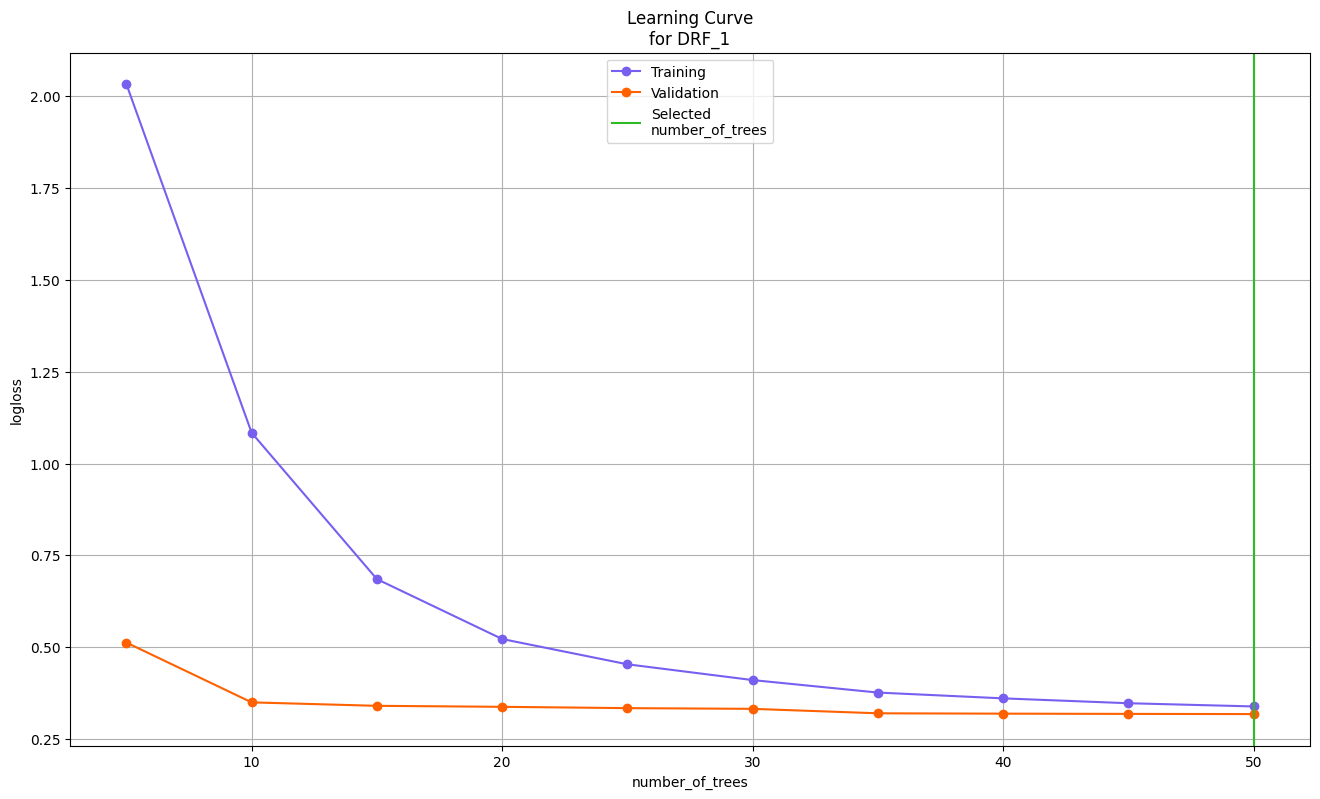

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

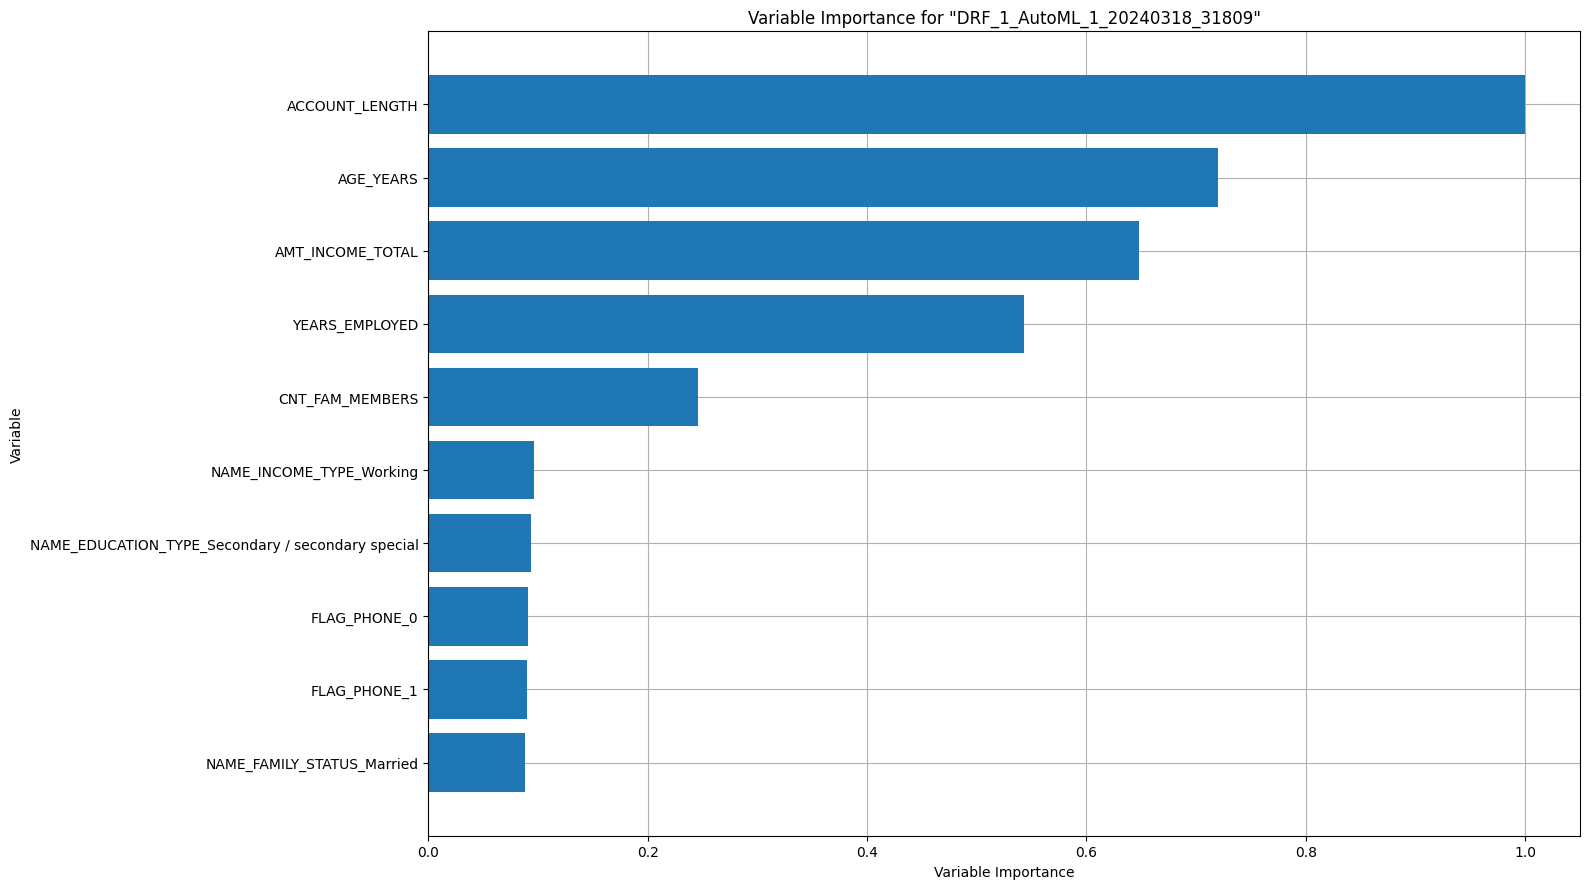

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

/usr/local/lib/python3.10/dist-packages/h2o/explanation/_explain.py:611: RuntimeWarning: invalid value encountered in divide
  res = (res - np.nanmin(res)) / (np.nanmax(res) - np.nanmin(res))


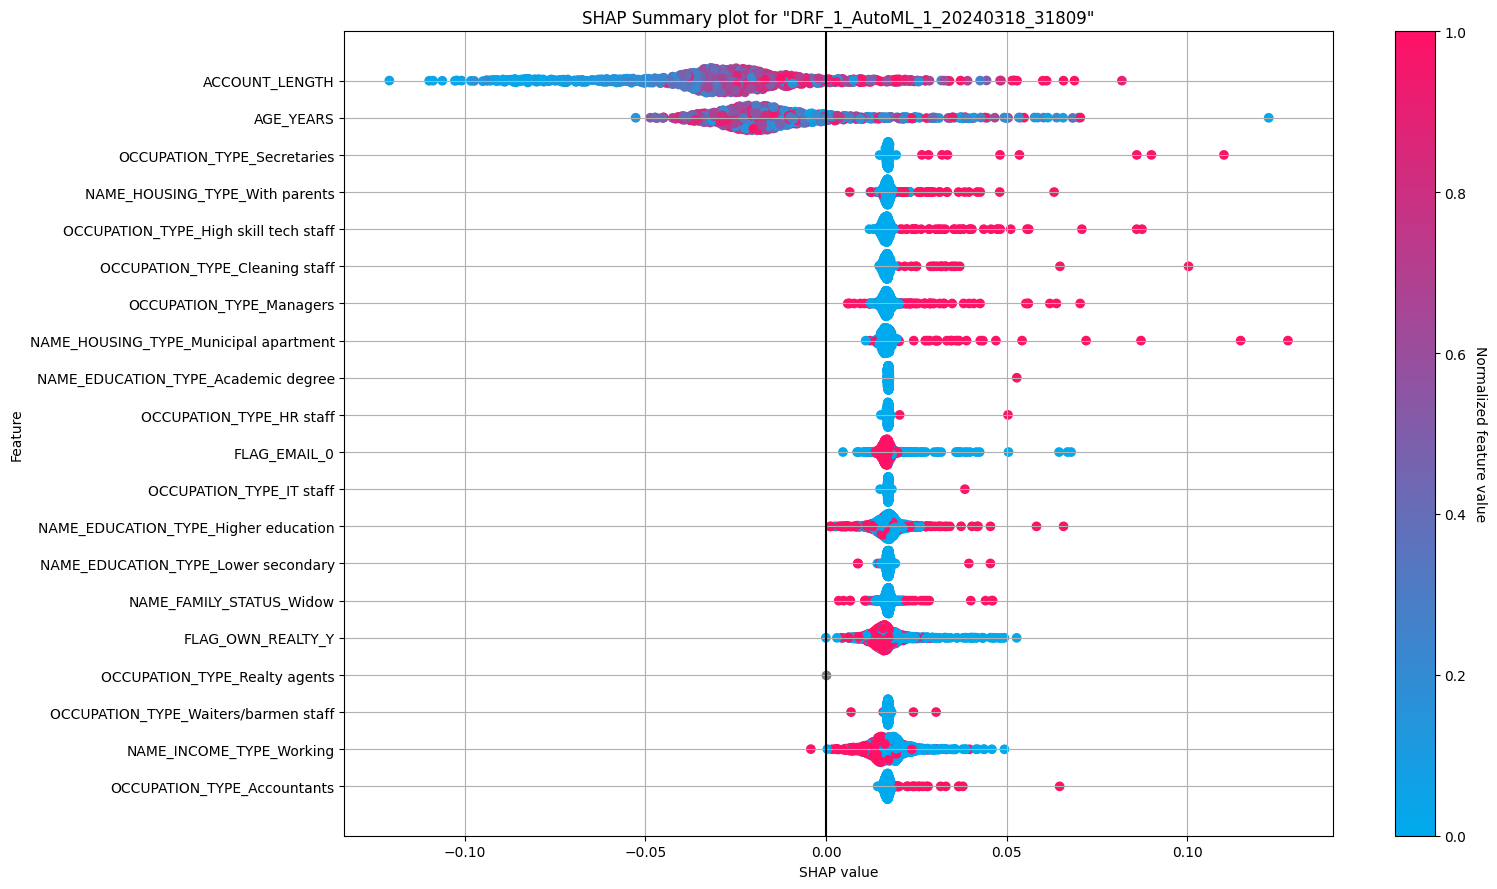

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

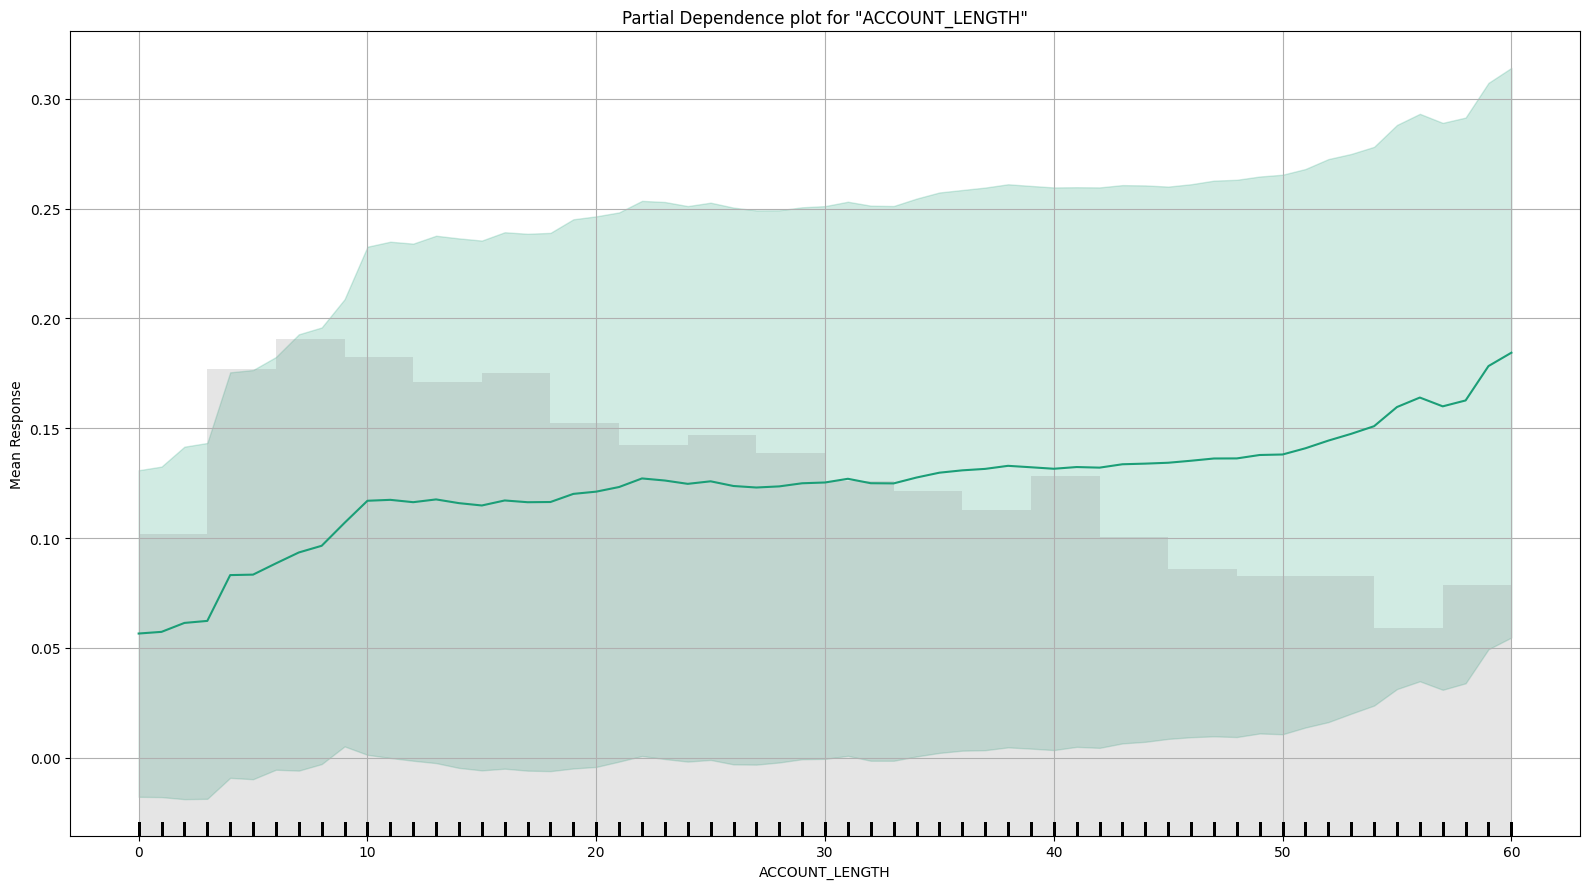

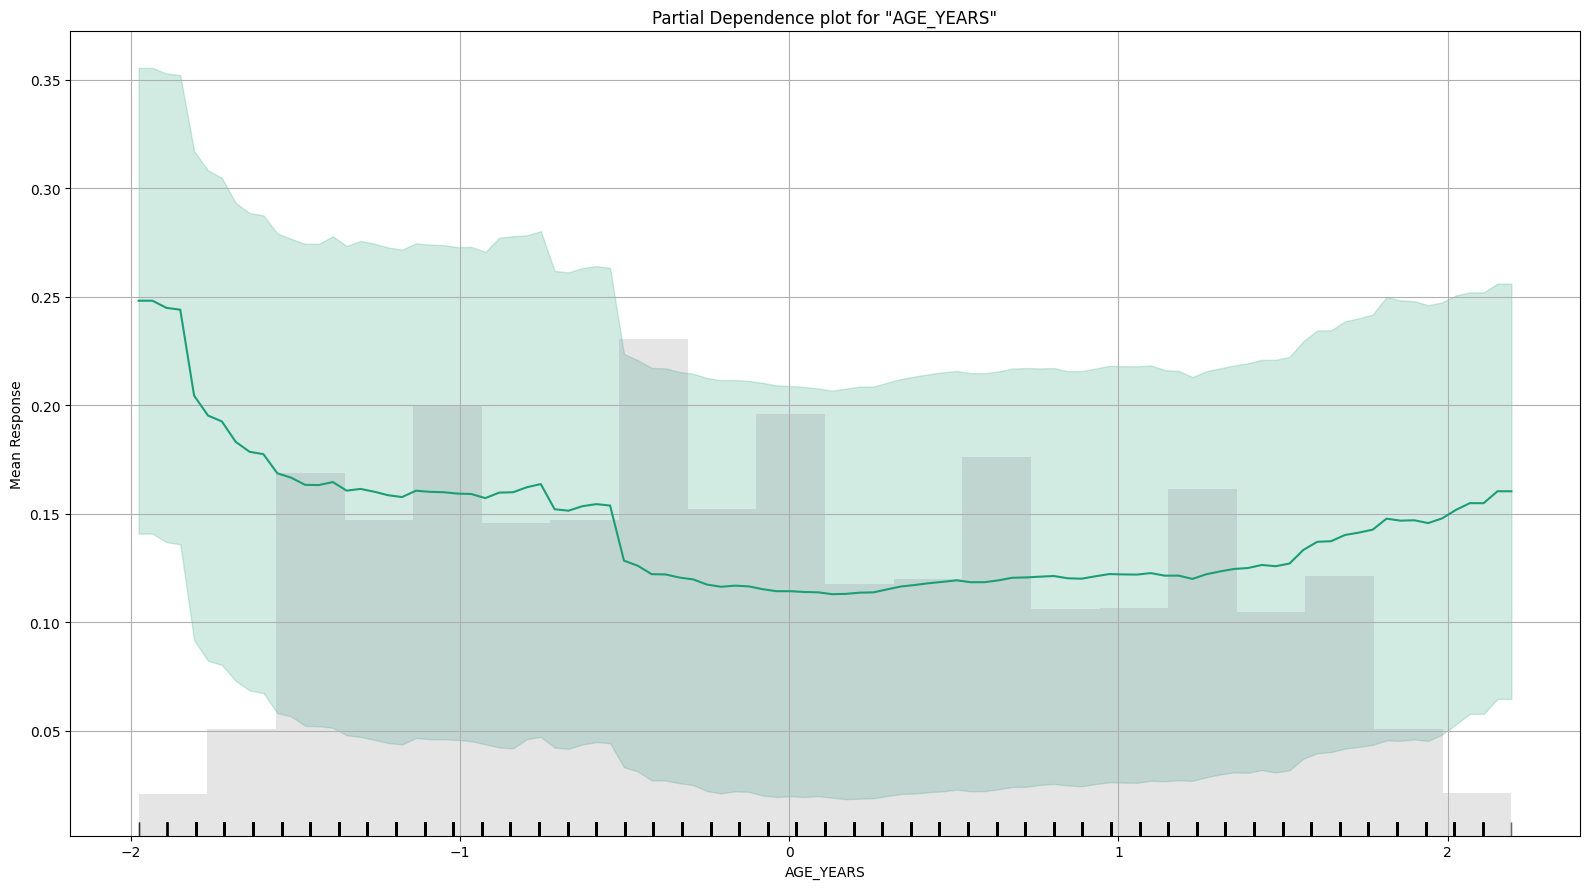

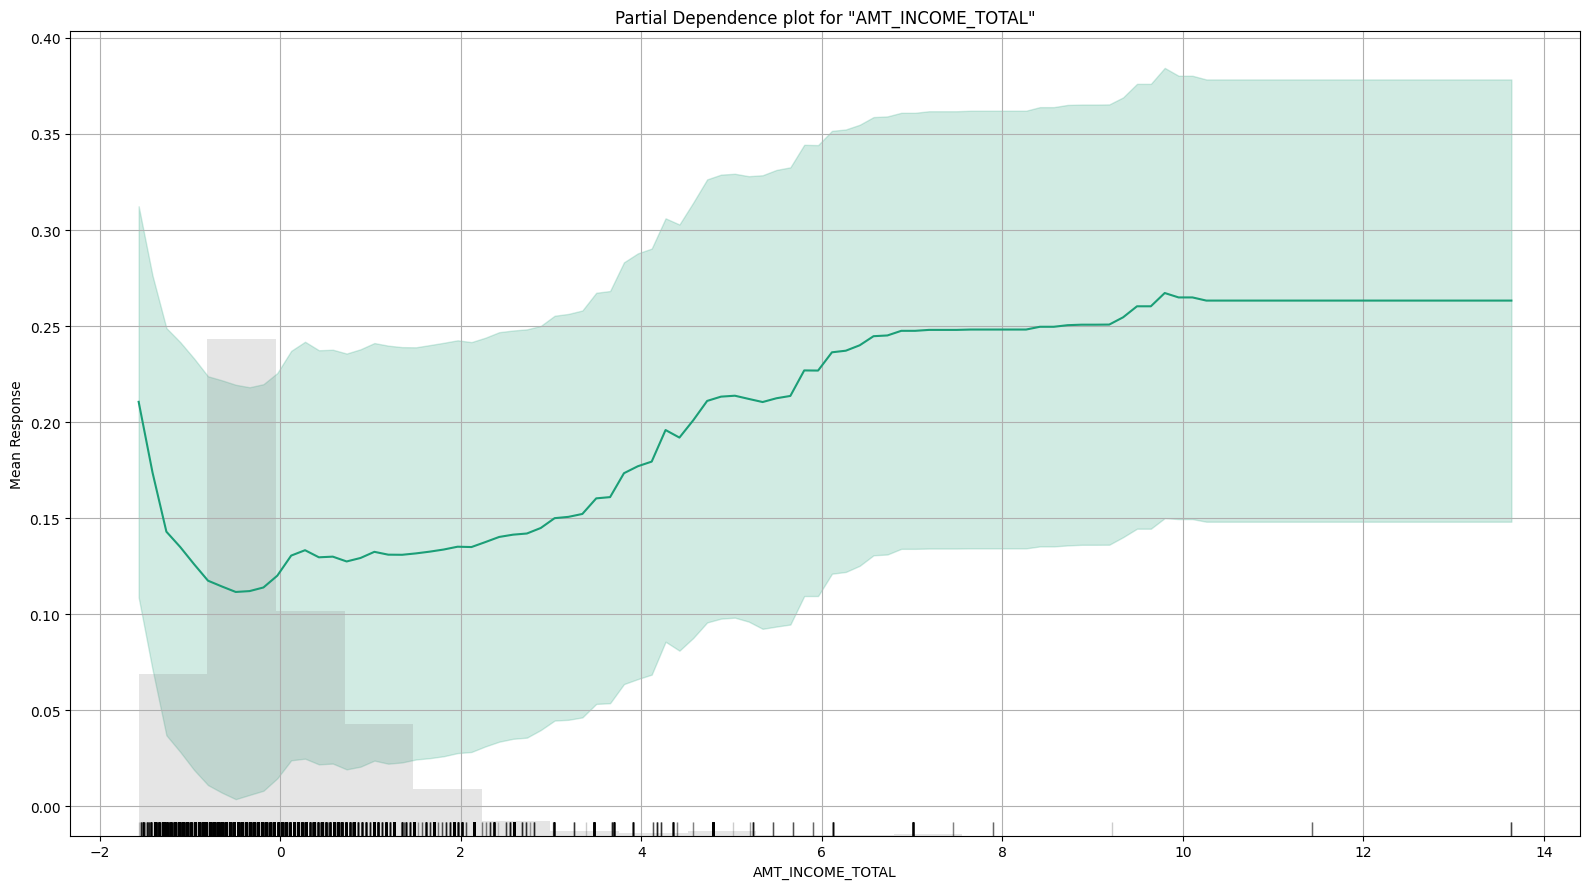

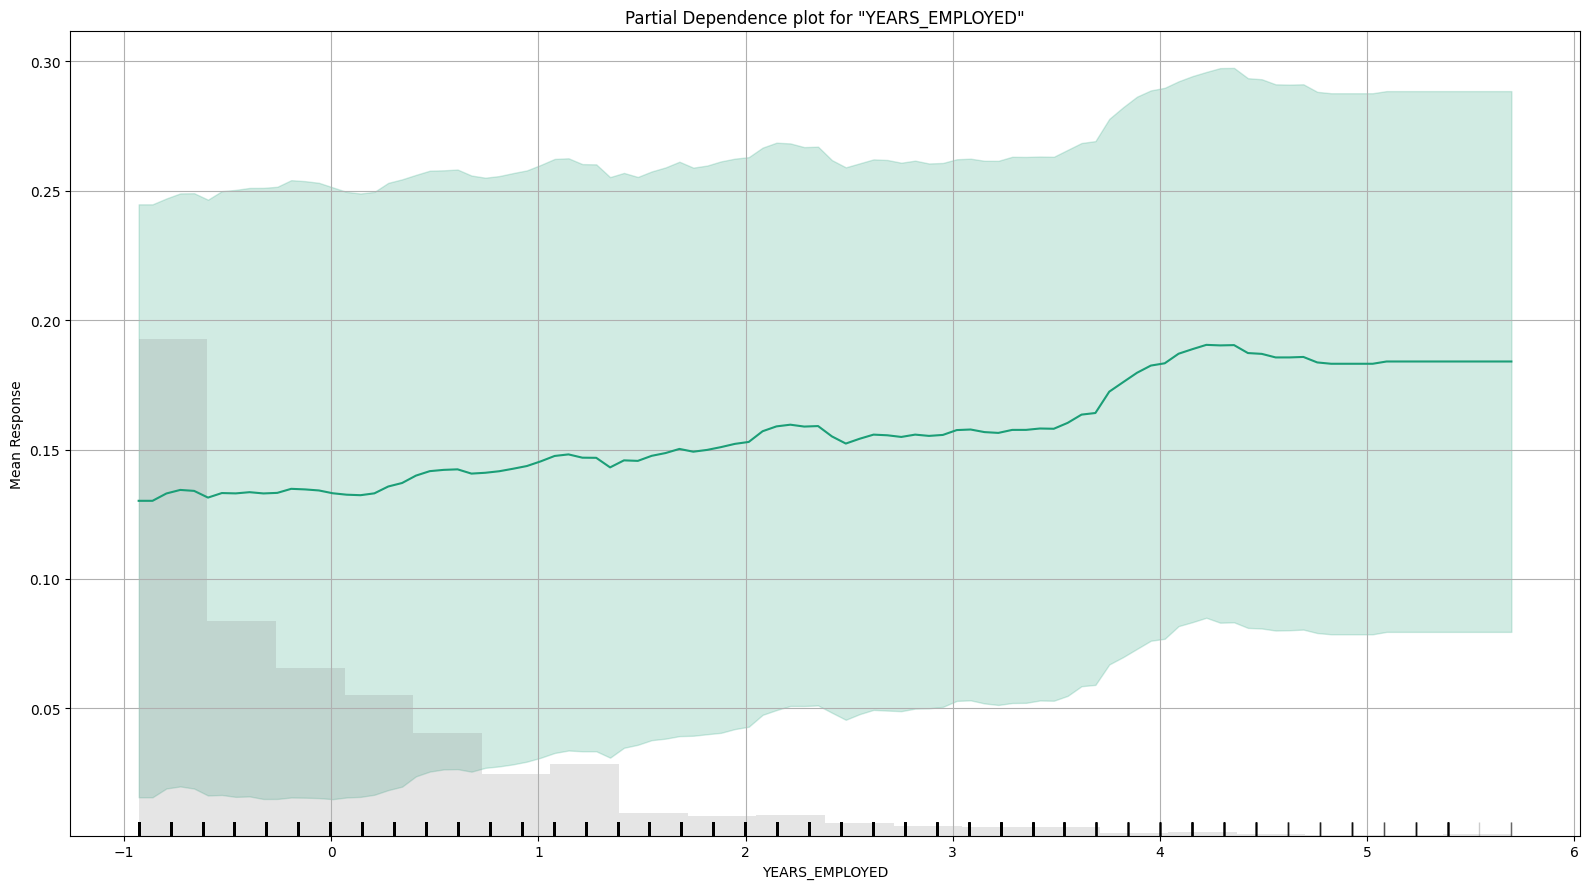

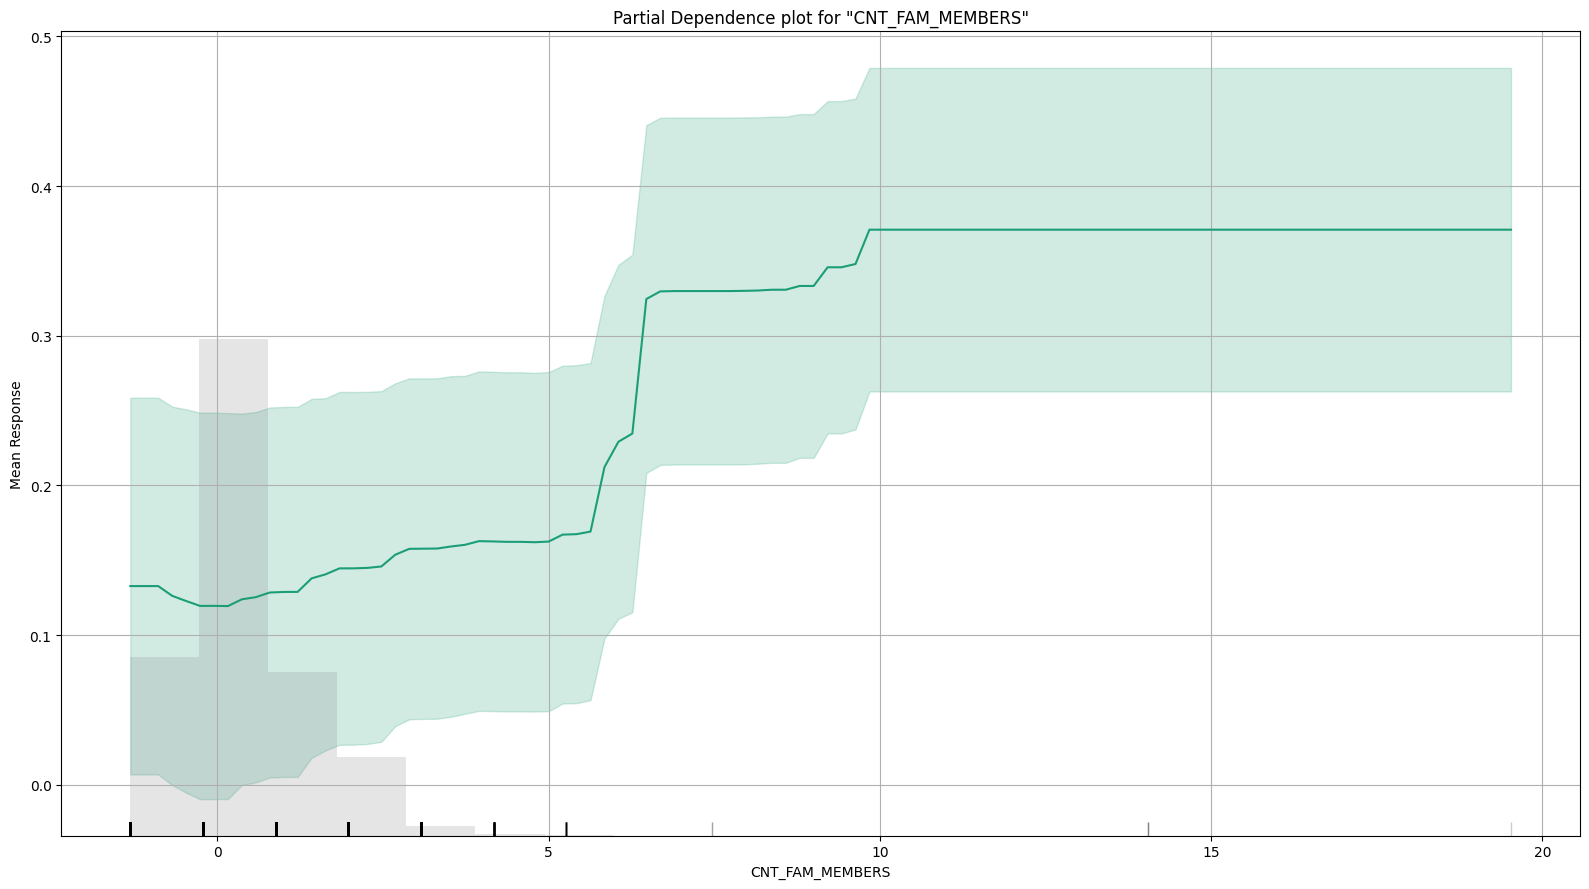

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## DRF_1_AutoML_1_20240318_31809

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26747104202878885
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      24970  875   0.0339   (875.0/25845.0)
1      962    2484  0.2792   (962.0/3446.0)
Total  25932  3359  0.0627   (1837.0/29291.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

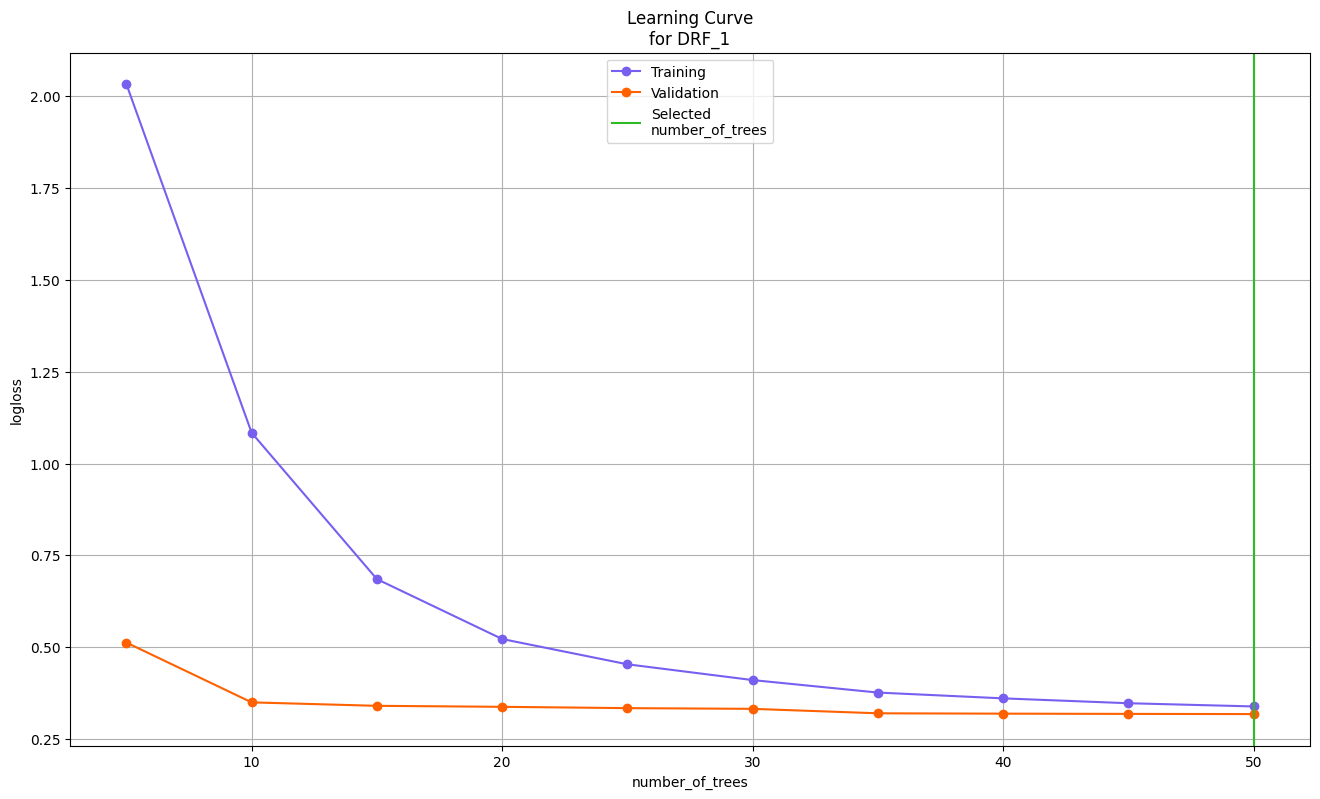

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

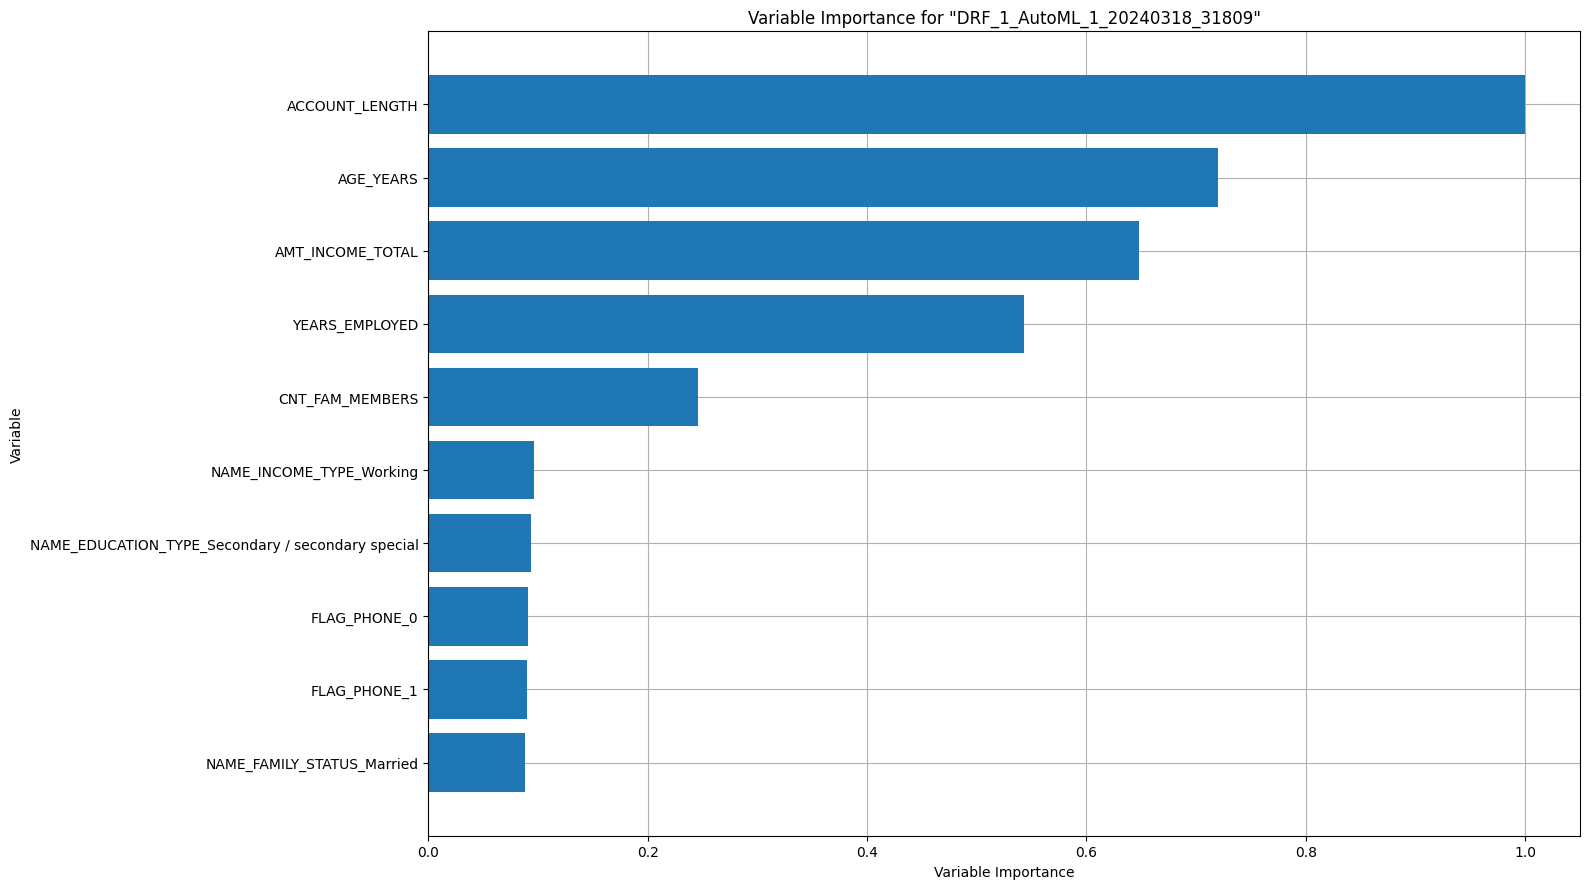

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

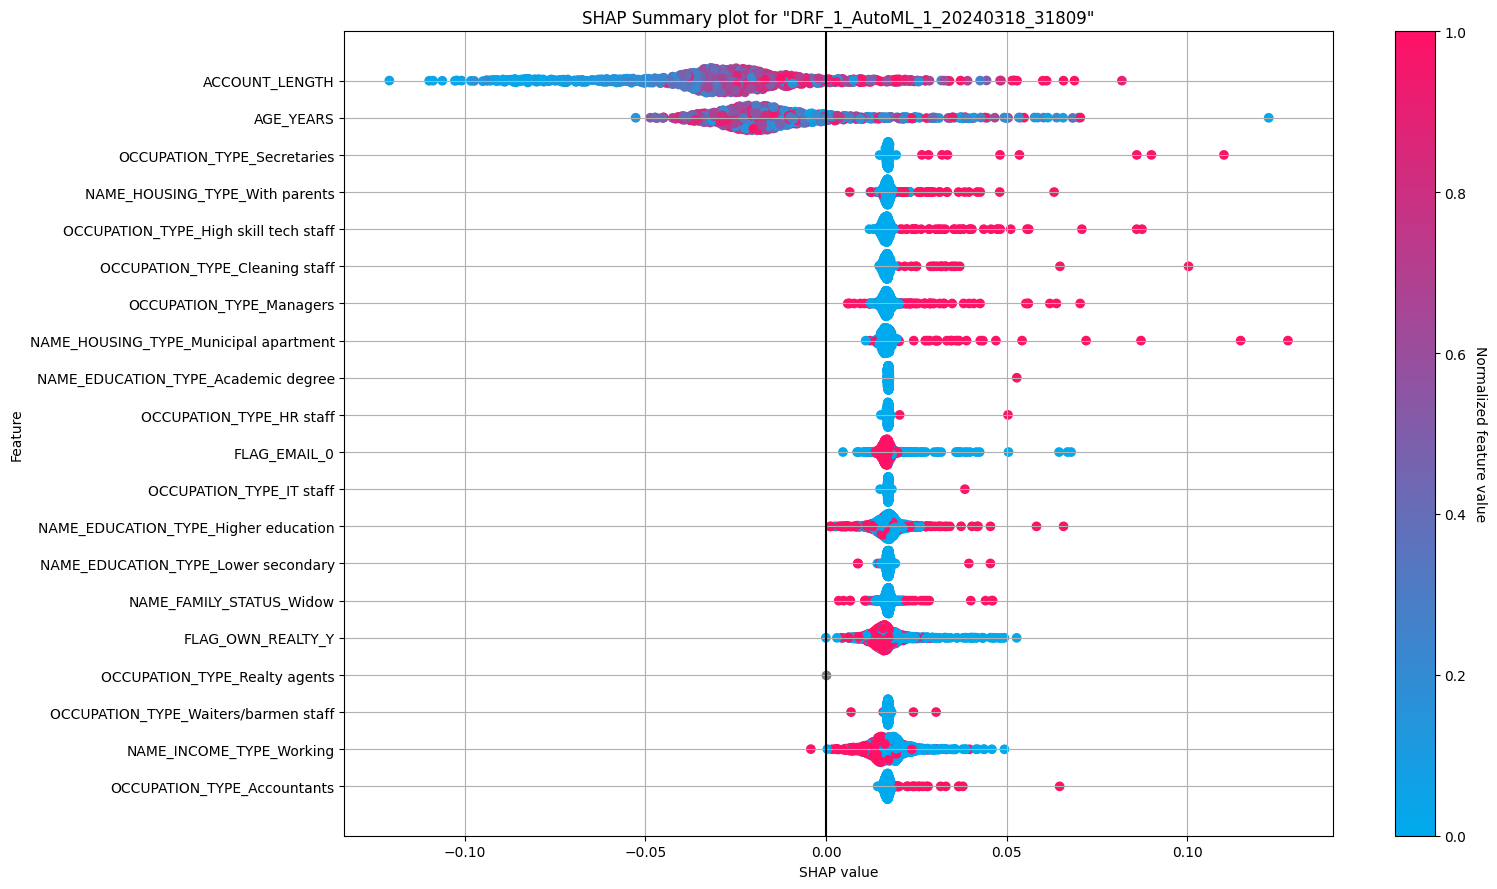

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

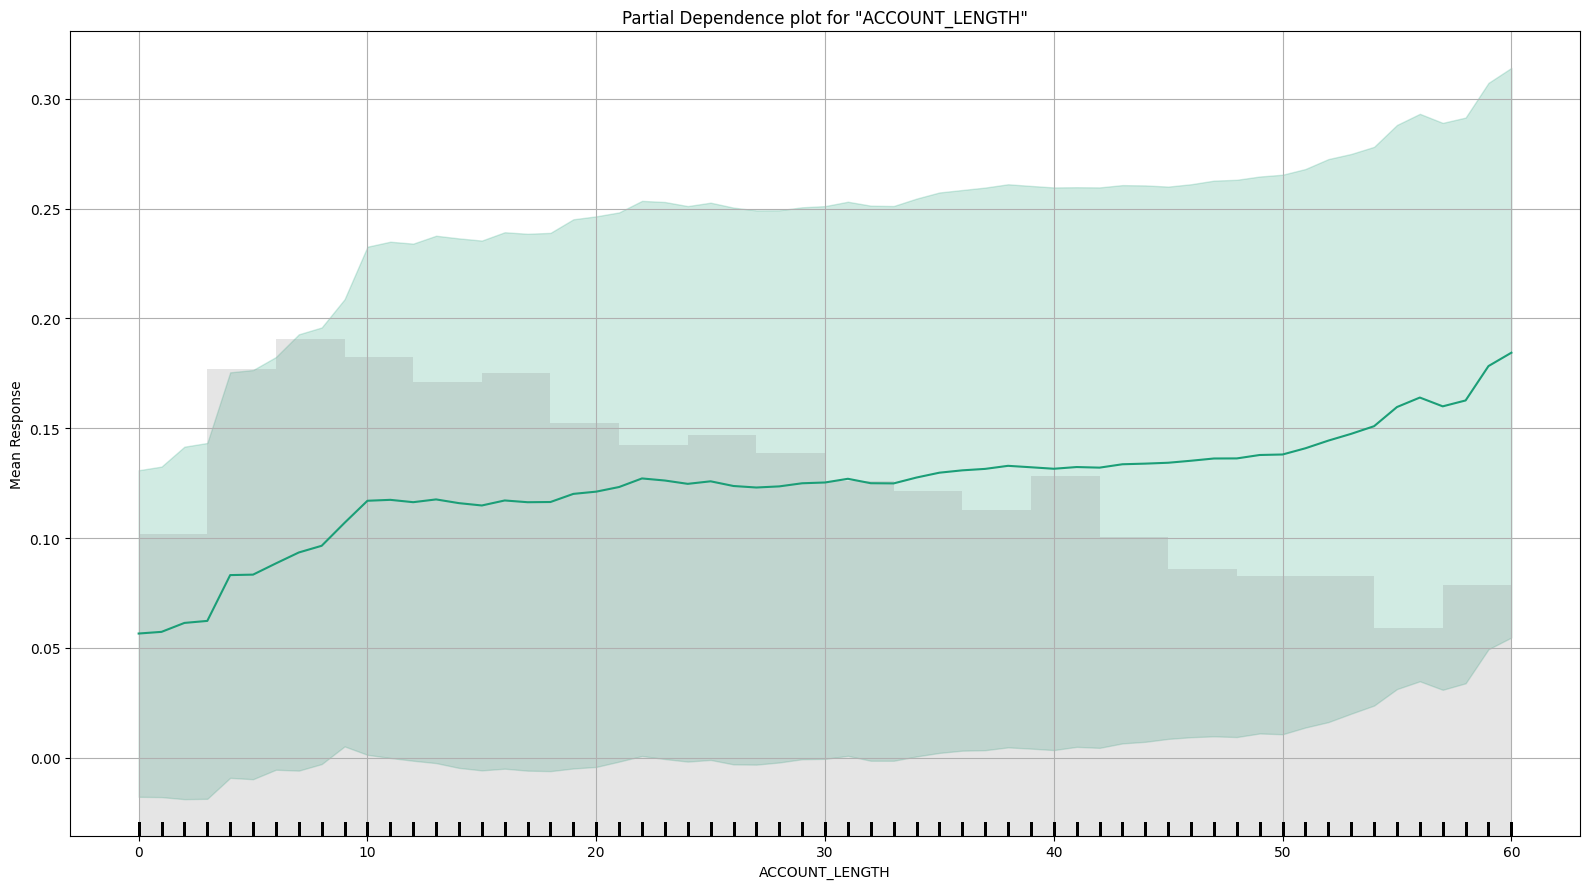

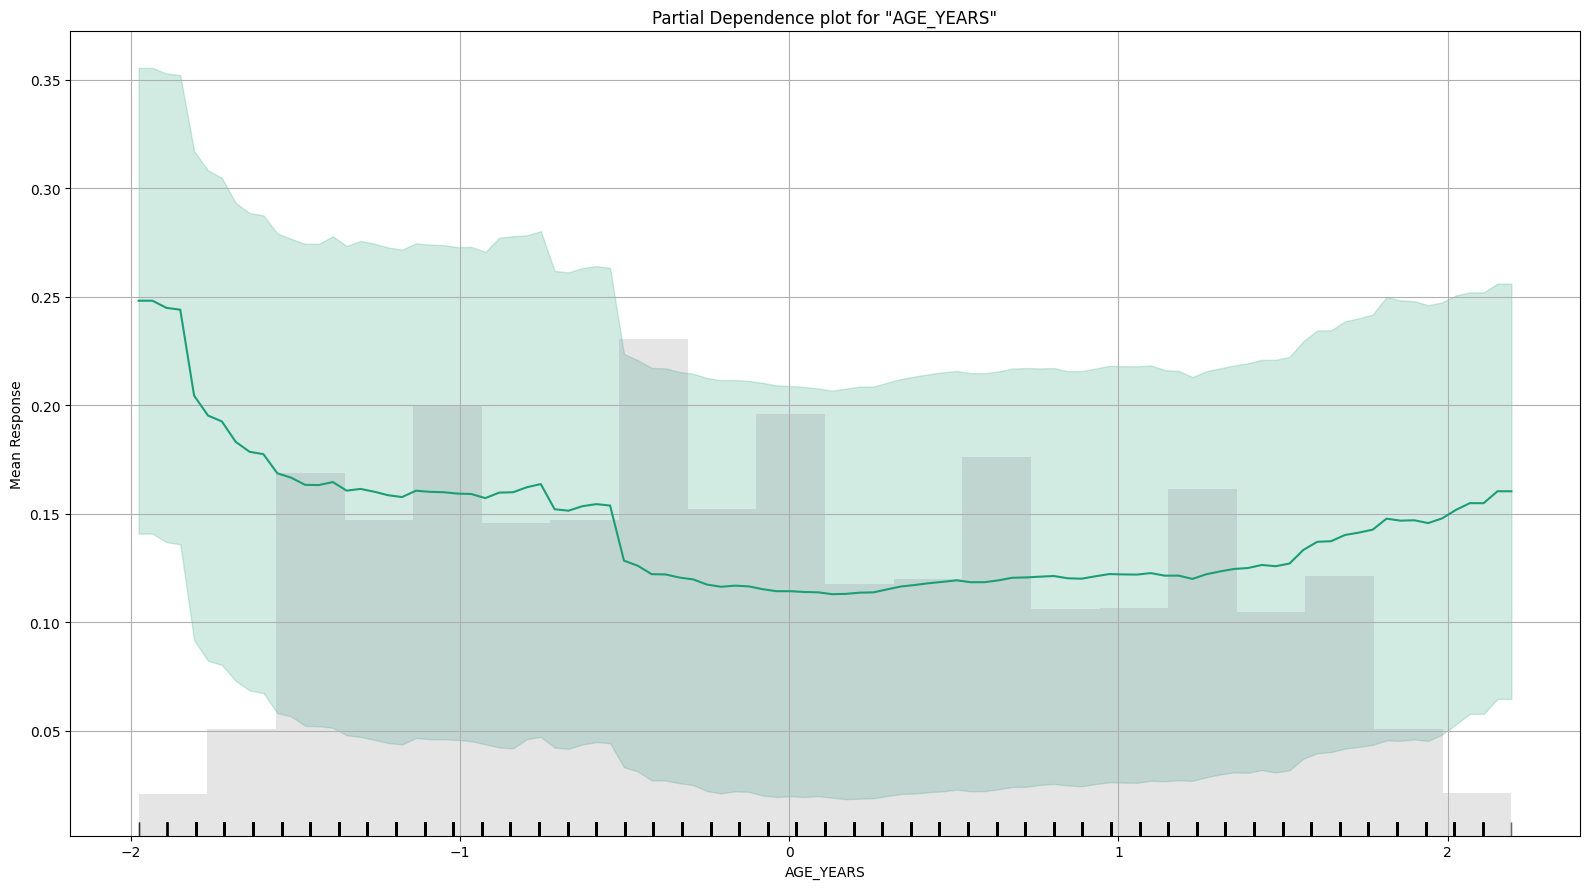

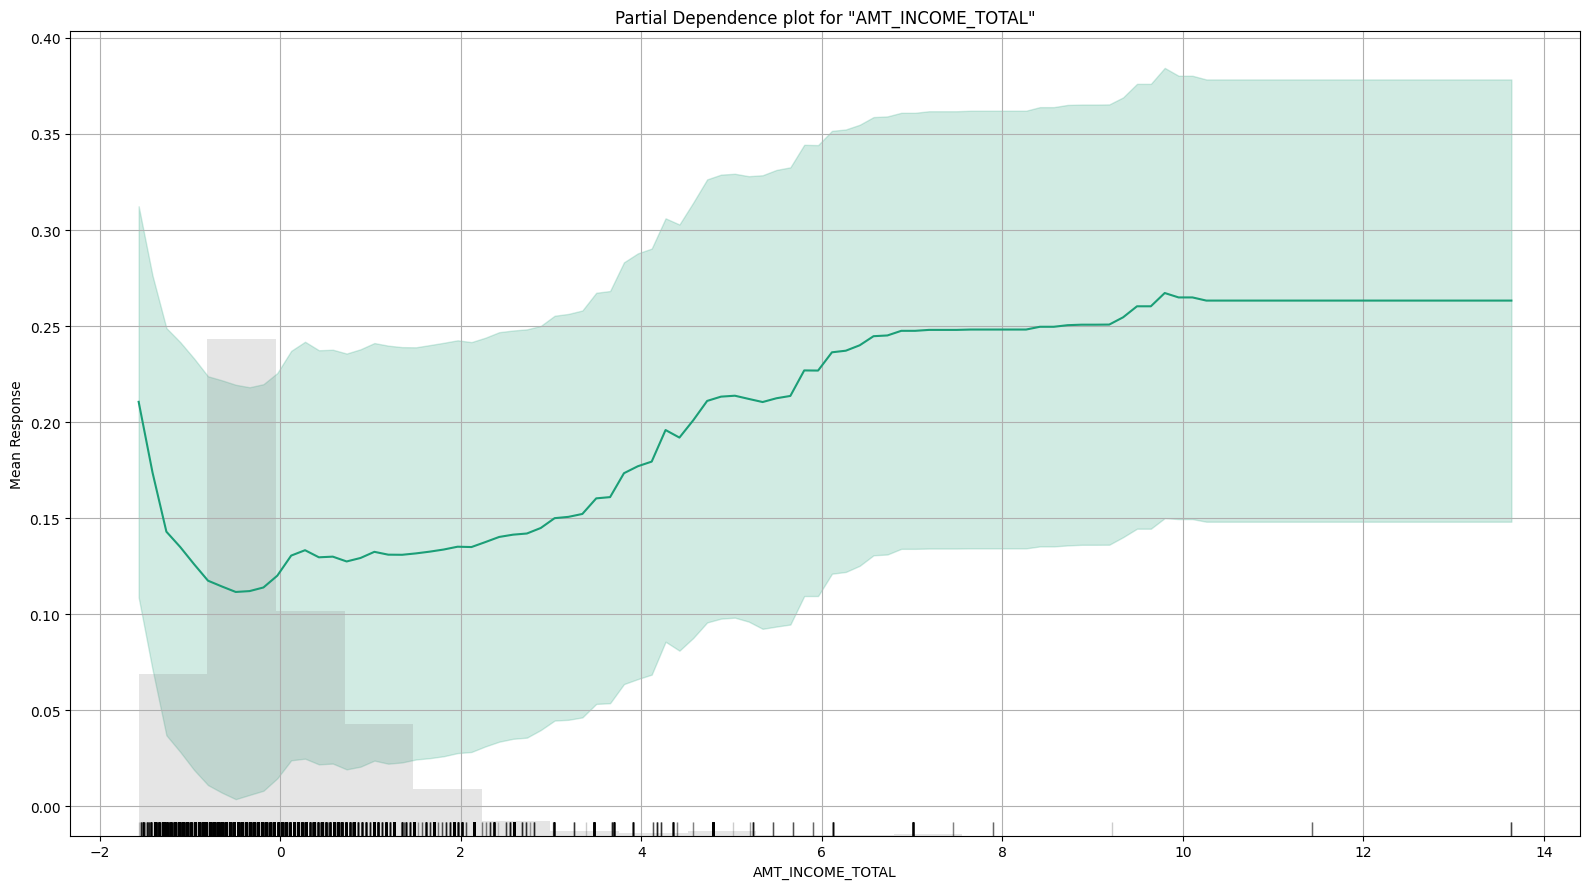

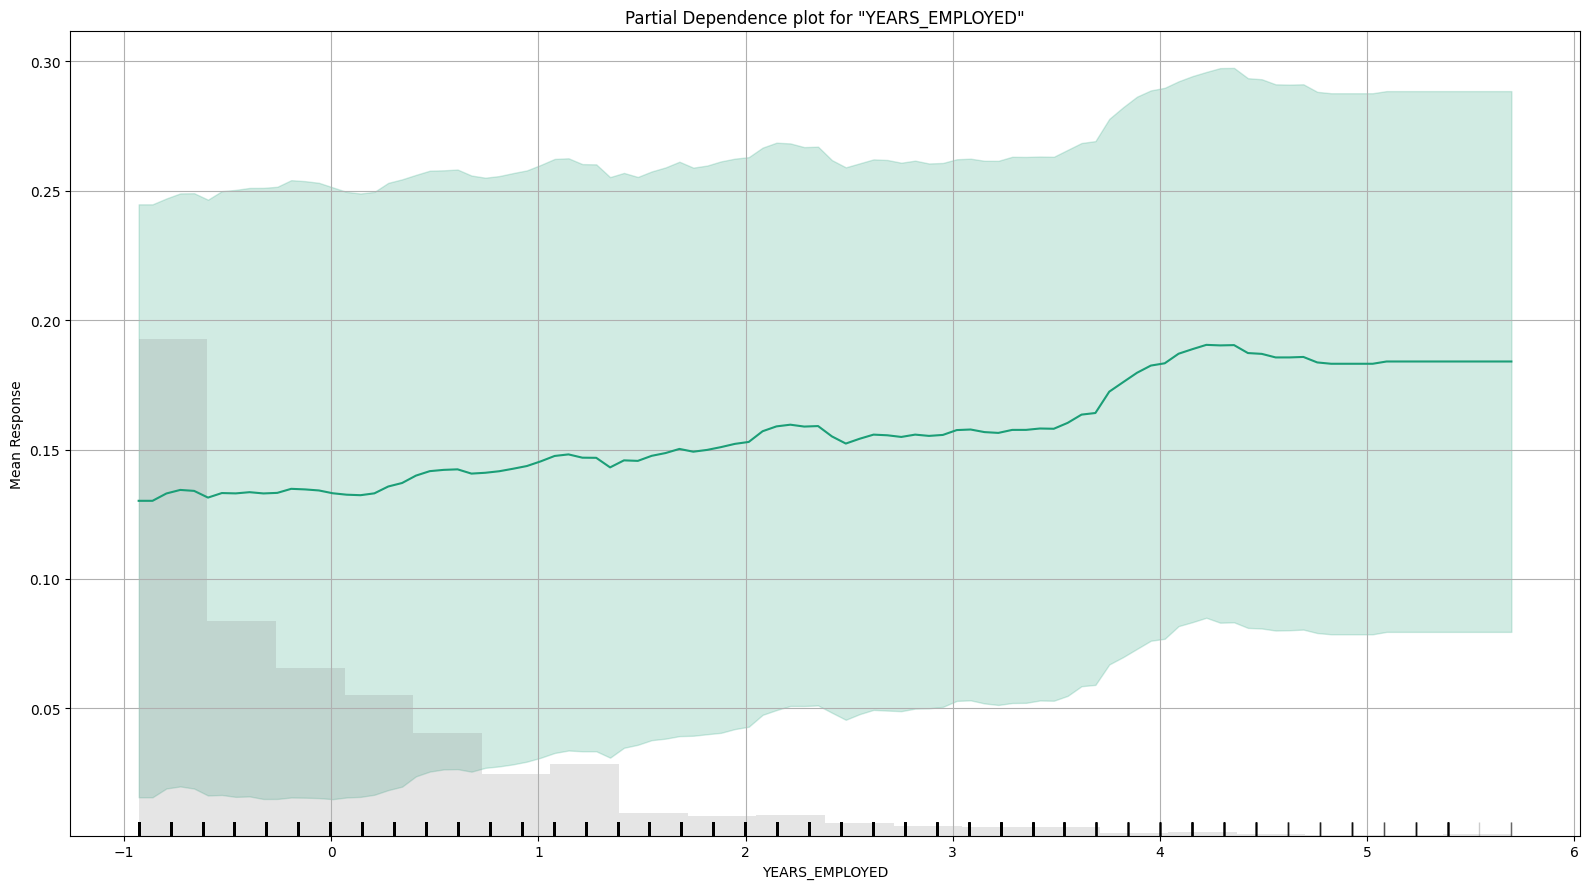

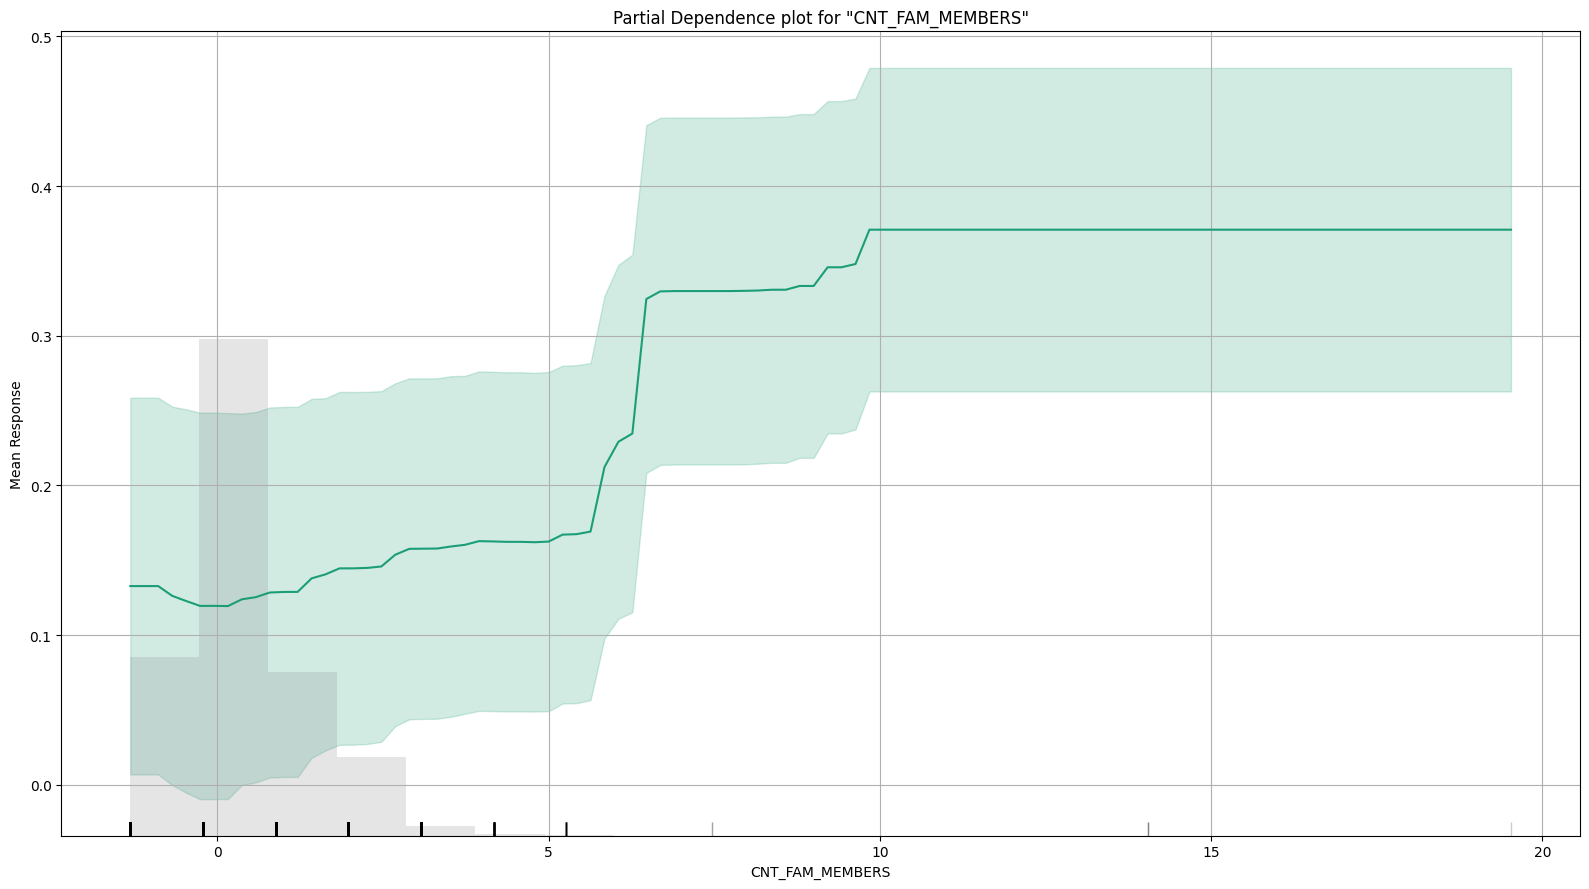

In [143]:
best_model.explain(data_train)

In [144]:
best_model.algo

'drf'

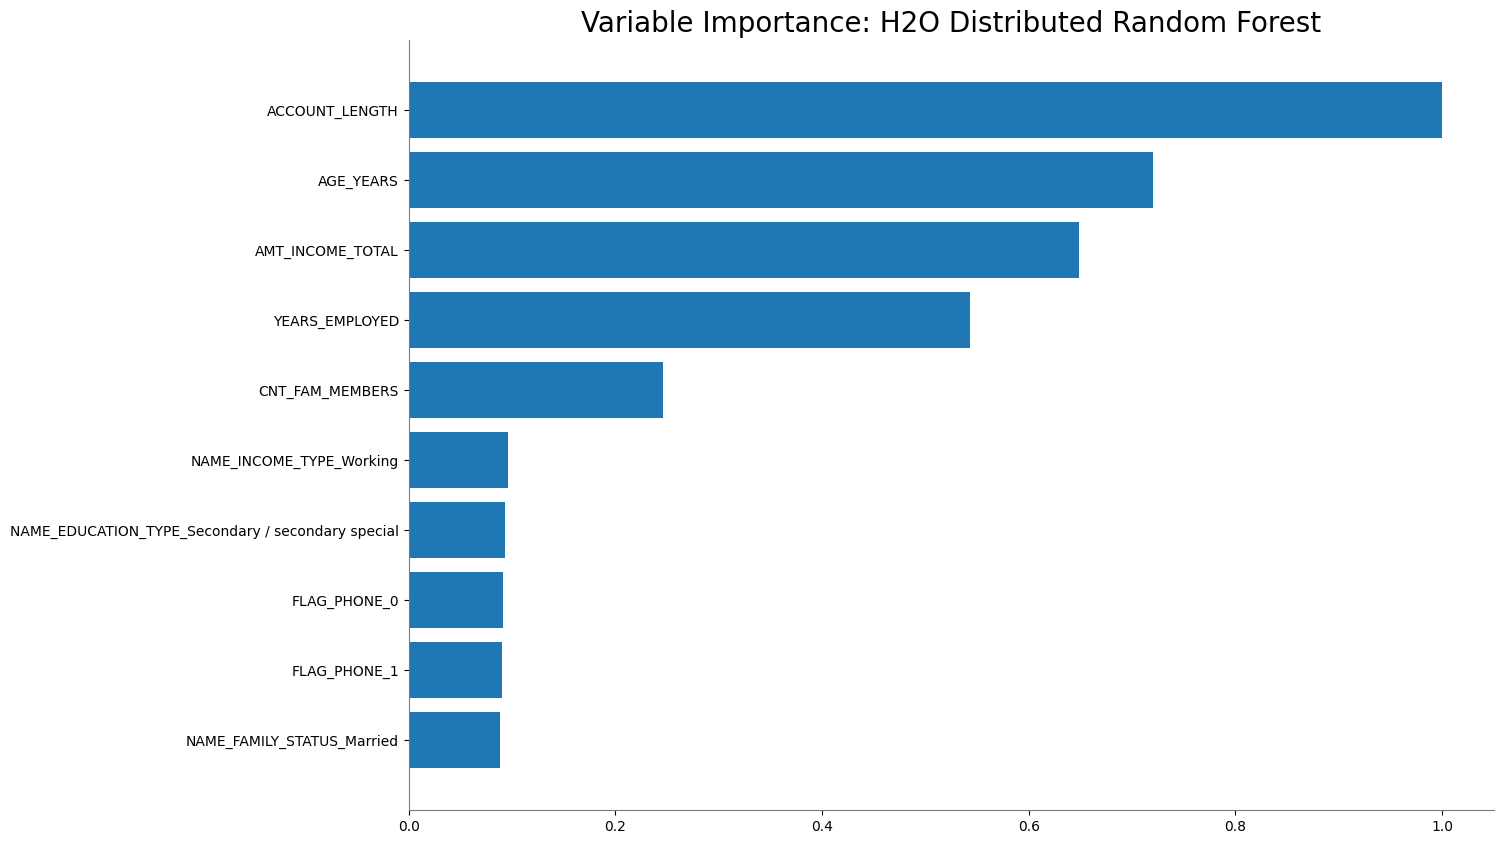

<Figure size 50000x10000 with 0 Axes>

In [145]:
if best_model.algo in ['gbm','drf','xrt','xgboost']:
  best_model.varimp_plot()

<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-146-7ab4cd191751>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if glm_index is not 0:


24
glm


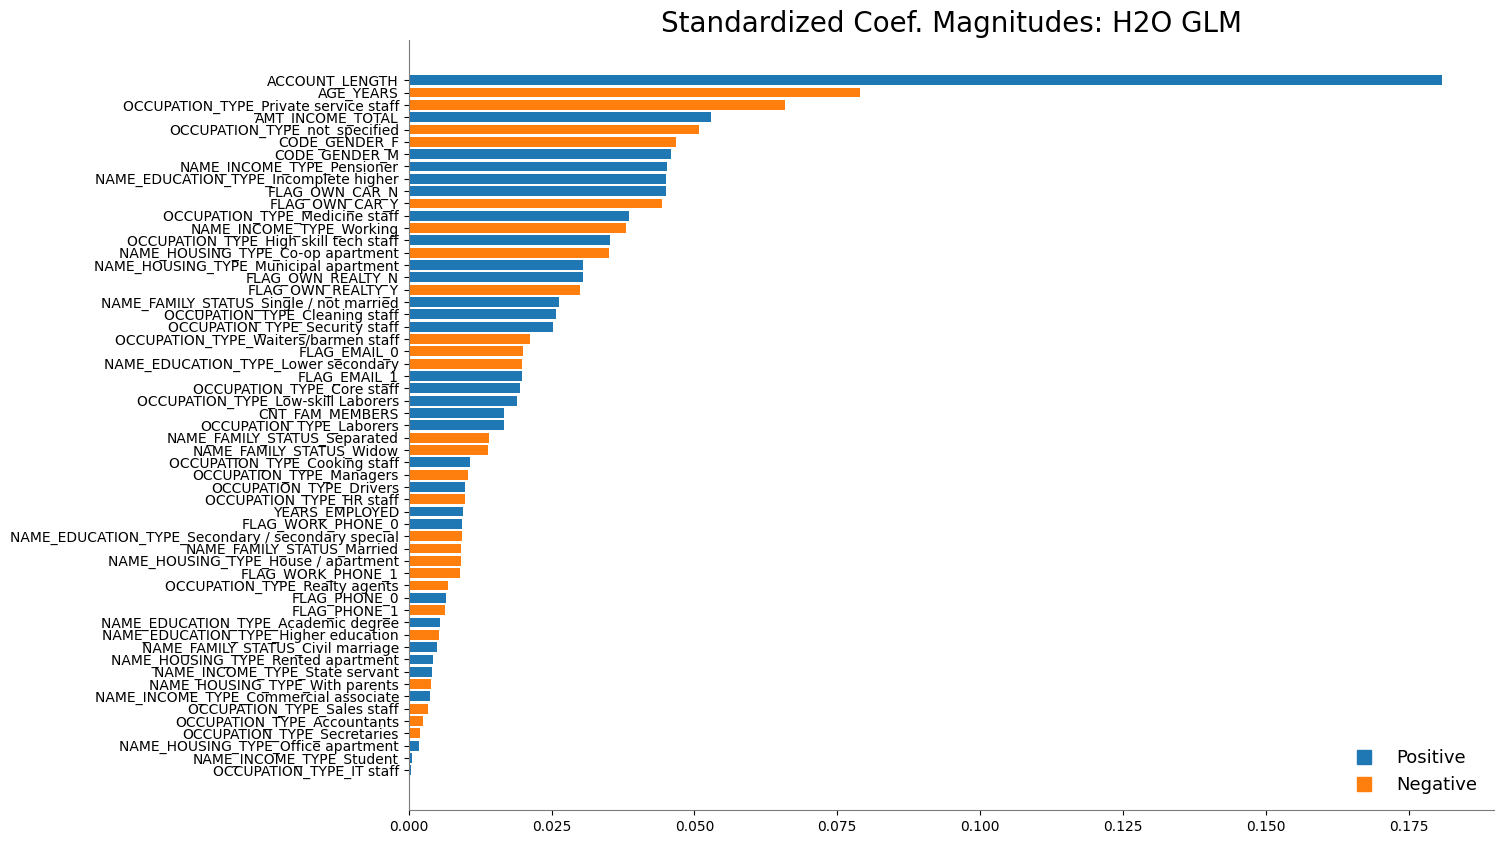

In [146]:
if glm_index is not 0:
  print(glm_index)
  glm_model=h2o.get_model(auml.leaderboard[glm_index,'model_id'])
  print(glm_model.algo)
  glm_model.std_coef_plot()

In [147]:
print(best_model.auc(train = True))

0.7185038917358291


In [148]:
def model_performance_stats(perf):
    d={}
    try:
      d['mse']=perf.mse()
    except:
      pass
    try:
      d['rmse']=perf.rmse()
    except:
      pass
    try:
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass
    try:
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass
    try:
      d['residual_deviance']=perf.residual_deviance()
    except:
      pass
    try:
      d['null_deviance']=perf.null_deviance()
    except:
      pass
    try:
      d['aic']=perf.aic()
    except:
      pass
    try:
      d['logloss']=perf.logloss()
    except:
      pass
    try:
      d['auc']=perf.auc()
    except:
      pass
    try:
      d['gini']=perf.gini()
    except:
      pass
    return d

In [149]:
mod_perf=best_model.model_performance(data_test)
stats_test={}
stats_test=model_performance_stats(mod_perf)
stats_test

{'mse': 0.09053610540519352,
 'rmse': 0.30089218235971754,
 'null_degrees_of_freedom': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'null_deviance': None,
 'aic': 'NaN',
 'logloss': 0.3159125309897738,
 'auc': 0.735061862917728,
 'gini': 0.47012372583545603}

##ANS 3 - Interpreting the performance of the best model
##Regression Metrics:
MSE (Mean Squared Error):
0.09053610540519352
0.09053610540519352. This represents the average of the squares of the errors or deviations—that is, the difference between the estimator and what is estimated. A lower MSE value indicates a better fit to the data.
RMSE (Root Mean Squared Error):
0.30089218235971754
0.30089218235971754. This is the square root of MSE and similarly indicates the model's fit to the data, with lower values indicating a better fit. It is in the same units as the response variable and is often considered more interpretable than MSE.
Classification Metrics:
LogLoss (Logarithmic Loss):
0.3159125309897738
0.3159125309897738. LogLoss measures the performance of a classification model where the prediction input is a probability value between 0 and 1. A lower LogLoss value indicates a better model.
AUC (Area Under the ROC Curve):
0.735061862917728
0.735061862917728. AUC measures the ability of the model to distinguish between the classes. The higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. Values range from 0 to 1, with a value of 0.5 denoting a model that makes predictions as good as random guessing.
Gini Coefficient:
0.47012372583545603
0.47012372583545603. The Gini coefficient is derived from the AUC and measures the inequality among the values of a frequency distribution (for example, levels of income). For model evaluation, a higher Gini coefficient indicates a better model. It is calculated as
2
×
AUC
−
1
2×AUC−1, so the provided value aligns with the AUC value given.
Other Metrics:
Null Degrees of Freedom: Not provided. This typically relates to the number of independent values that can vary in the calculation of a statistical parameter.
Residual Degrees of Freedom: Not provided. This represents the number of independent pieces of information available to estimate the residuals.
Residual Deviance: Not provided. In the context of generalized linear models, this measures the goodness of fit of a model. Lower values indicate better fit.
Null Deviance: Not provided. This represents the difference between a model with only the intercept and the saturated model. It is a measure of goodness of fit.
AIC (Akaike Information Criterion): 'NaN'. This measures the relative quality of a statistical model for a given set of data. A lower AIC value indicates a better model. 'NaN' suggests that the value couldn't be computed or is not applicable for this model.

## Initialising the shap analysis on the model from step 1,2,3


In [150]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.1 MB/s eta 0:00:00


SHAP Analysis: Typically, SHAP values provide a detailed view of the impact each feature has on the model's predictions. Features with higher absolute SHAP values are considered more important. The analysis often includes visualizations like summary plots and beeswarm plots that showcase the distribution of SHAP values for each feature across all predictions, highlighting their positive or negative impact on the model's outcome.

Feature Importance: This is often model-specific and can come from tree-based model outputs like XGBoost or GBM, where the importance is based on metrics such as gain, cover, or frequency of features used in splits. The identified cell related to feature importance likely contains a ranked list or a plot illustrating the relative importance of each feature in the model's decision-making process.



In [151]:
import shap

In [152]:
lg_explainer = shap.Explainer(logreg, x_train)
shap_values_lg = lg_explainer(x_test)

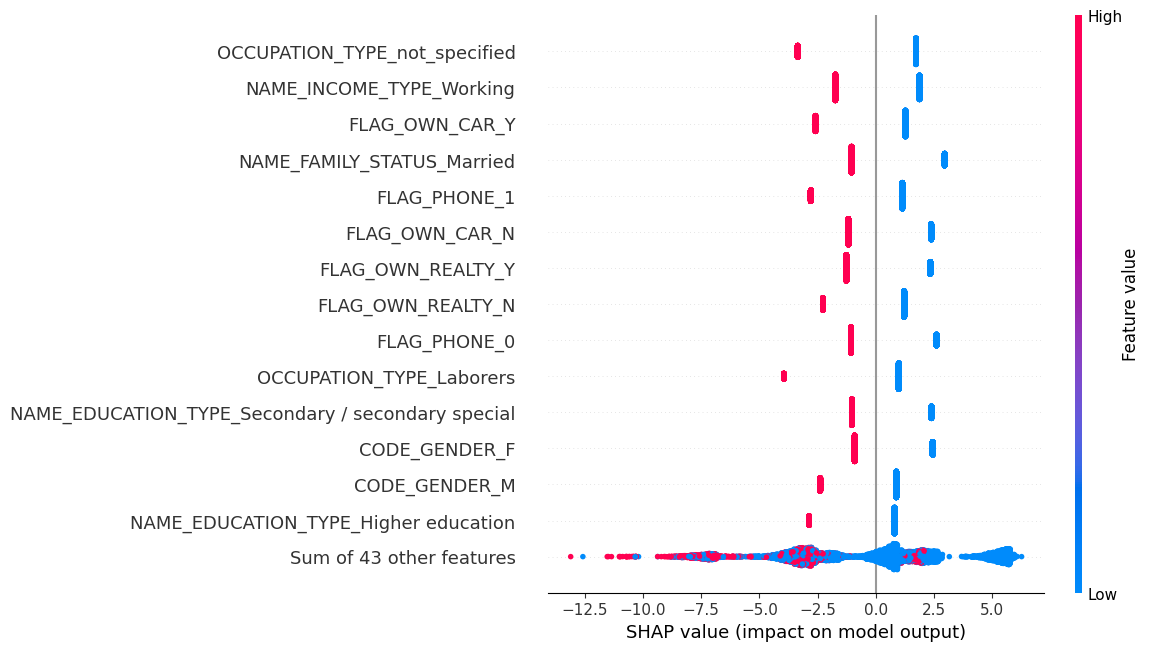

In [153]:
shap.plots.beeswarm(shap_values_lg, max_display=15)

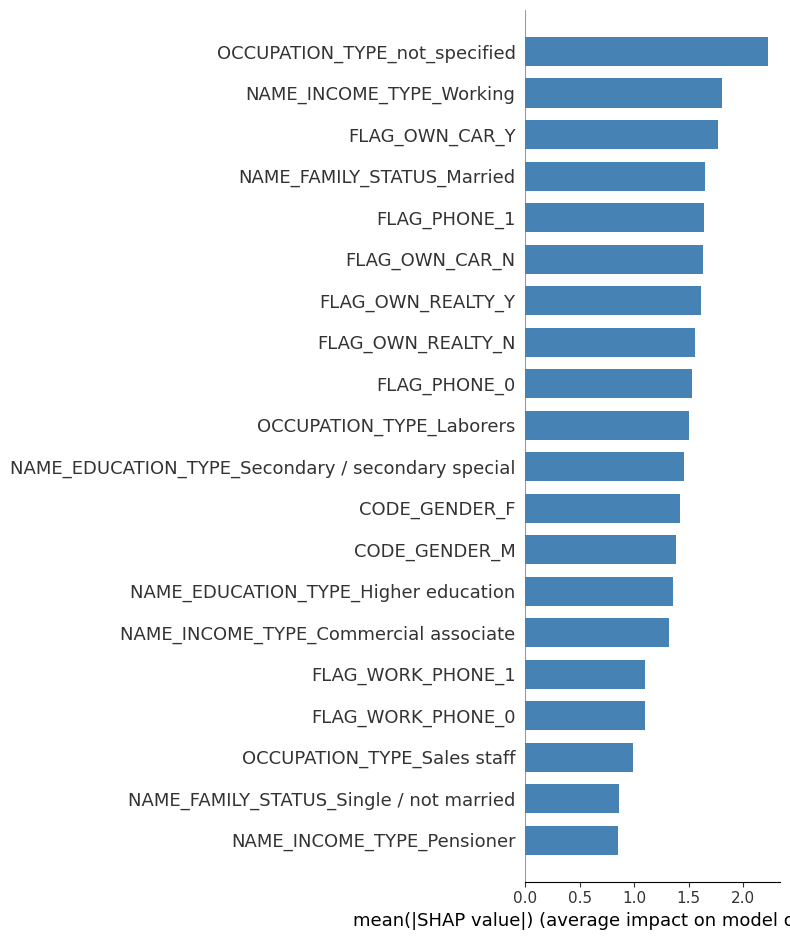

In [154]:
shap.summary_plot(shap_values_lg, x_train, plot_type="bar", color='steelblue')

In [155]:
explainer = shap.TreeExplainer(xgb_cl)
shap_values = explainer.shap_values(x_train,approximate=False, check_additivity=False)

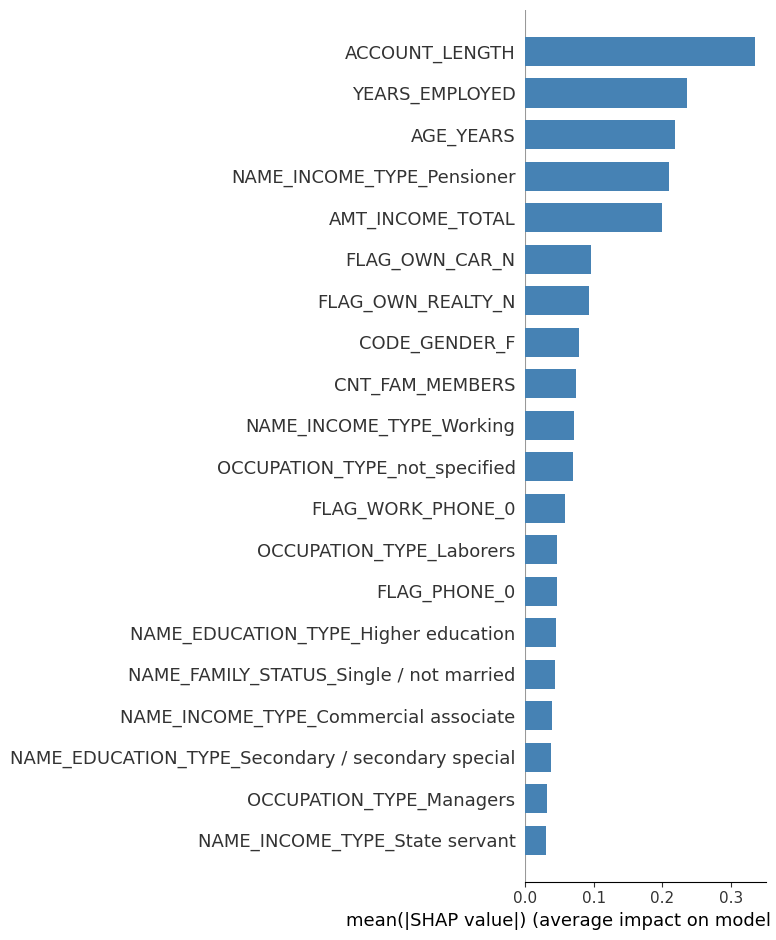

In [156]:
shap.summary_plot(shap_values, x_train, plot_type="bar", color='steelblue')

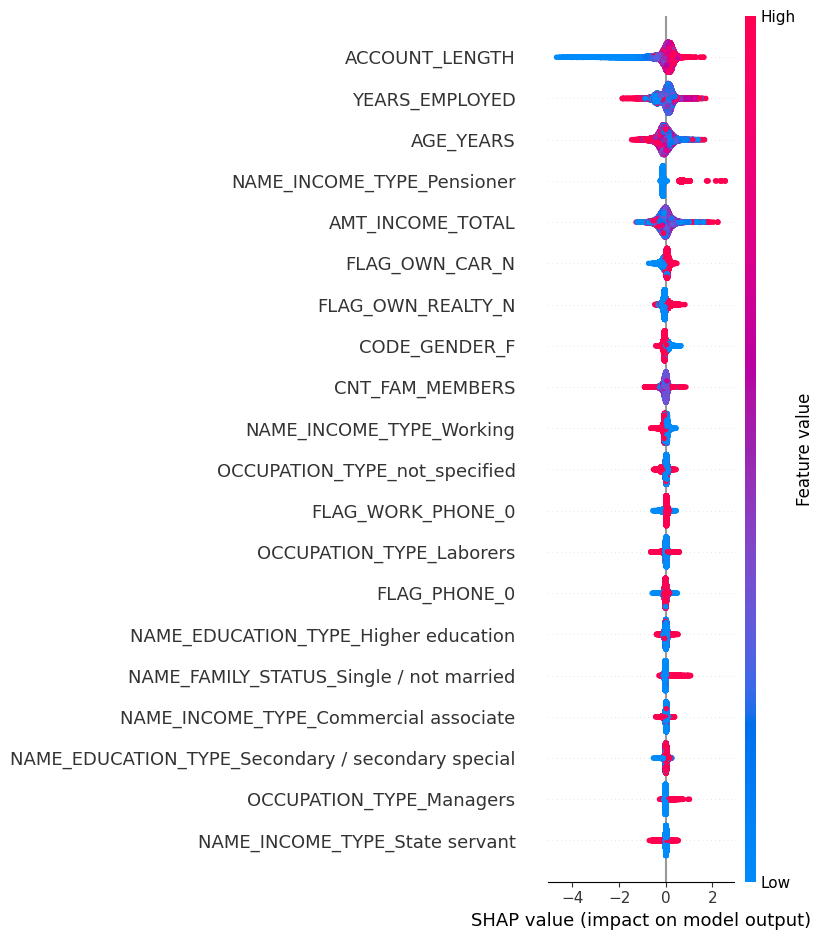

In [157]:
shap.summary_plot(shap_values, x_train)

## Q4 - Run SHAP analysis on the models from steps 1, 2, and 3,   interpret the SHAP values and compare them with the other model interpretability methods.
## ANS 4


After running SHAP analysis on the given model, we observe that 'ACCOUNT_LENGTH' is the top feature impacting the model's output, as represented in this beeswarm plot. Features like 'YEARS_EMPLOYED' and 'AGE_YEARS' also have significant impacts, with higher values leading to more considerable shifts in the output prediction. The beeswarm plot indicates that higher values of 'ACCOUNT_LENGTH', 'YEARS_EMPLOYED', and 'AGE_YEARS' are associated with the outcome of interest.

Conversely, features at the bottom of the plot such as 'OCCUPATION_TYPE_Laborers' and 'FLAG_WORK_PHONE_0' appear to have the least impact on the model's output. Their positions suggest that changes in these features lead to smaller shifts in the prediction compared to more dominant features like 'ACCOUNT_LENGTH'.

The pink and blue colors likely represent high and low feature values, respectively, influencing the prediction in opposite directions. For example, a high 'ACCOUNT_LENGTH' might lead to a higher likelihood of the event the model predicts (indicated by the pink color), while a lower 'ACCOUNT_LENGTH' (blue) could decrease the likelihood.

Each feature's impact on the model's output is not isolated; it also depends on the interaction with other features. However, this beeswarm plot provides a visualization of each feature's direct contribution, helping us understand the model's behavior in a more granular way. The SHAP values indicate the magnitude and direction of a feature's impact on the model prediction, offering insights into the relationship between feature values and the likelihood of the predicted outcome.

##CONCLUSION
Upon evaluation of the Logistic Regression, XGBoost, and AutoML models, SHAP analysis has revealed that each model values different sets of features. In the context of Credit card, features such as 'AGE_YEARS', 'YEARS_EMPLOYED', and 'ACCOUNT_LENGTH' often emerge as significant across different types of models. Regularization techniques were suggested to fine-tune the models, which could potentially adjust the feature importances and lead to improved performance and interpretability. The SHAP summary plots for each model would provide insight into how individual features shift the model's output, informing us of the direction and magnitude of their impact on the predicted probability of card approval.

## License

Copyright (c) 2022 Bhagya Trivedi

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### References
1)https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1

2)https://towardsdatascience.com/decision-trees-explained-3ec41632ceb6

3)https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/

4)https://www.analyticsvidhya.com/blog/2020/10/all-about-decision-tree-from-scratch-with-python-implementation/

5)https://www.kdnuggets.com/2020/04/visualizing-decision-trees-python.html

6)https://www.datacamp.com/community/tutorials/xgboost-in-python

7)https://github.com/MayurAvinash/DESM_INFO6105/blob/main/Model_Interpretability_Assignment.ipynb
